# Model Selection<br><sub>and Information Sharing and Information Criterion</sub>


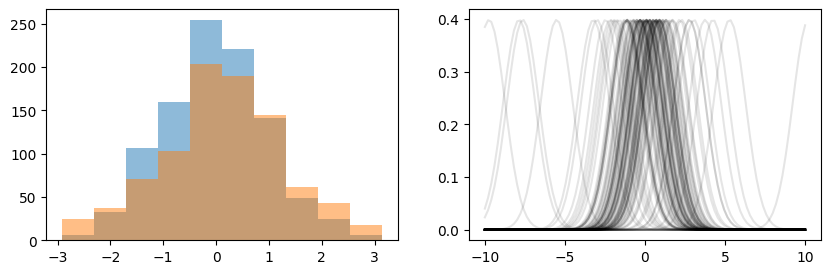

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

t = 1000
x = stats.norm().rvs(t)
y = stats.t(df=2).rvs(t)

fig,ax = plt.subplots(1,2, figsize=(10,3))
barh,bins,arts=ax[0].hist(x, alpha=0.5)
ax[0].hist(y, bins=bins, alpha=0.5)
#ax[0].set_yscale('log')

support = np.linspace(-10,10,100)
for i in range(100):
    ax[1].plot(support, stats.norm(loc=y[i],scale=1).pdf(support),
               'k', alpha=0.1)

In [ ]:
# t_df=2 samples have larger magnitude
(np.abs(y)>np.abs(x)).mean()-0.5

np.float64(0.09499999999999997)

In [ ]:
# fraction of standarized normal > 3
(np.abs(x)>3).mean()

np.float64(0.002)

In [ ]:
import pymc as pm

with pm.Model() as spike_and_slab:

    p = pm.Beta('p', alpha=1, beta=1)
    spike = pm.Bernoulli('spike', p=p, shape=t)
    slab = pm.Normal('slab', mu=0, sigma=100, shape=t)
    test = pm.Normal('test', mu=spike*slab, sigma=1, observed=y)

    idata = pm.sample()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


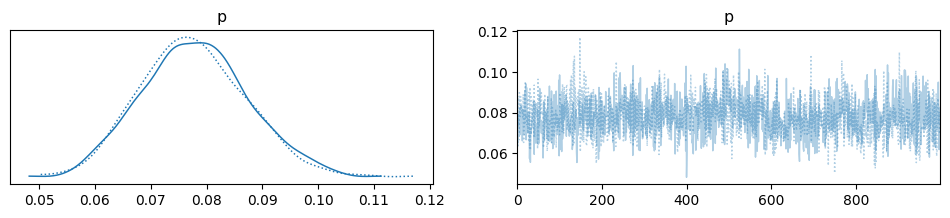

In [ ]:
import arviz as az

az.plot_trace(idata, var_names='p');

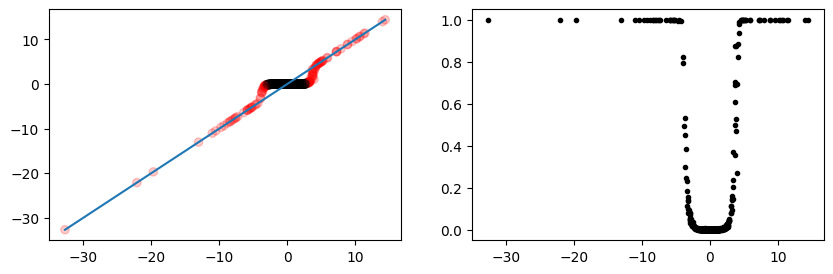

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,3))

c,d = idata.posterior['slab'].values.shape[:2]

outlier = (np.abs(y)>3)
col = ['r' if o else 'k' for o in outlier]
ax[0].plot([y.min(),y.max()], [y.min(),y.max()])
ax[0].scatter(y,
              (idata.posterior['slab'].values.reshape(c*d,t)*
               idata.posterior['spike'].values.reshape(c*d,t)).mean(axis=0),
              color=col, alpha=0.2)

ax[-1].plot(y,
            idata.posterior['spike'].values.reshape(c*d,t).mean(axis=0),'k.');

In [ ]:
with pm.Model() as horseshoe:

    tau_0 = 0.1  # pm.Beta('p_non0', alpha=1, beta=1)
    tau = pm.HalfCauchy('tau', beta=tau_0, shape=1)
    lambdas = pm.HalfCauchy('lambdas', beta=1, shape=t)
    mu_ = pm.Normal('mu_', mu=0, sigma=1, shape=t)
    mu = pm.Deterministic('mu', mu_*tau*lambdas)
    test = pm.Normal('test', mu=mu, sigma=1, observed=y)

    idata2 = pm.sample()

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    171           0.03        255          21.98 draws/s    0:01:30   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    153           0.01        255          11.11 draws/s    0:02:59   0:00:00

ERROR:pymc.stats.convergence:There were 324 divergences after tuning. Increase `target_accept` or reparameterize.


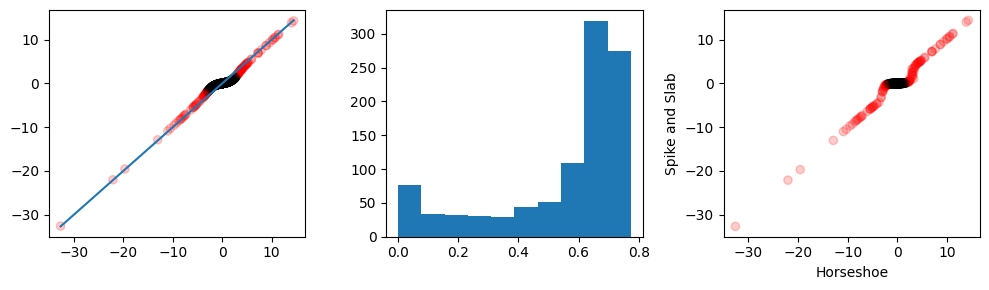

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(10,3))

outlier = (np.abs(y)>3)
col = ['r' if o else 'k' for o in outlier]
ax[0].plot([y.min(),y.max()], [y.min(),y.max()])
ax[0].scatter(y,
              idata2.posterior['mu'].values.reshape(c*d,t).mean(axis=0),
              color=col, alpha=0.2)

ax[1].hist(1/(1+(idata2.posterior['tau'].values*
                 idata2.posterior['lambdas'].values).reshape(c*d,t).mean(axis=0)**2));

ax[2].scatter(idata2.posterior['mu'].values.reshape(c*d,t).mean(axis=0),
              (idata.posterior['slab'].values.reshape(c*d,t)*
               idata.posterior['spike'].values.reshape(c*d,t)).mean(axis=0),
              color=col, alpha=0.2)
ax[2].set_ylabel("Spike and Slab")
ax[2].set_xlabel("Horseshoe")

plt.tight_layout()

## Bayesian Occam's Razor

$\begin{align*}
\Pr(M|x) &\propto{} \int f(x|\theta,M) p(\theta|M) p(M) d \theta\\
\Pr(M[u_i=0]|y_i) &\propto{} \int N(y_i|0,1) (1-p)^{1-u_i} p(p) dp = \int_0^1 N(y_i|0,1) (1-p)^1 dp = N(y_i|0,1)\\
\Pr(M[u_i=1]|y_i) &\propto{} \int\int N(y_i|\theta,1) N(\theta|0,100) p^{u_i} p(p) dp d\theta = \int N(y_i|\theta,1) N(\theta|0,100) d\theta \\
\end{align*}$

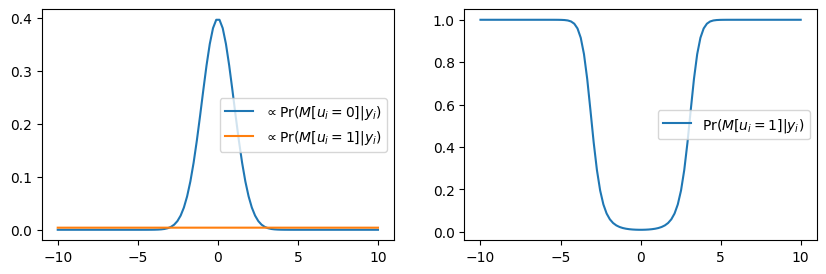

In [ ]:
from scipy import integrate

def Pr_M_u_0(y):
    return stats.norm(0,1).pdf(y)

@np.vectorize
def Pr_M_u_1(y):
    return integrate.quad(lambda 𝜃: stats.norm(𝜃,1).pdf(y)*stats.norm(0,100).pdf(𝜃),
                          -500, 500)[0]

fig,ax = plt.subplots(1,2,figsize=(10,3))

support = np.linspace(-10,10,100)
Pr_M_u_0_ = Pr_M_u_0(support)
Pr_M_u_1_ = Pr_M_u_1(support)

ax[0].plot(support, Pr_M_u_0_, label="$\\propto \\Pr(M[u_i=0]|y_i)$")
ax[0].plot(support, Pr_M_u_1_, label="$\\propto \\Pr(M[u_i=1]|y_i)$")
ax[0].legend()

ax[1].plot(support, Pr_M_u_1_/(Pr_M_u_1_+Pr_M_u_0_), label="$\\Pr(M[u_i=1]|y_i)$")
ax[1].legend();


The **Bayesian Occam's razor** phenomenon is a **curse of (parameter) dimensionality** which encourages simpler models to have larger marginal likelihoods than more complex models. We can generally expect that

$$p(\mathbf{x}|M_{\theta}) = \int f(\mathbf{x}|\theta) p(\theta)d\theta > \int\int f(\mathbf{x}|\theta, \eta) p(\theta, \eta) d\theta d\eta = p(\mathbf{x}|M_{\theta, \eta})$$

because the density of the prior $p(\theta, \eta)$ must be reduced to in relation to the increased volume in increasingly higher demensional (parameter) space.

---

Marginal likelihoods are small if
- prior specification are badly non-overlapping with the likelihood
- or if the data model cannot adequately reflect the empirical data distribution

Added model complexity that sufficiently increases likelihood to overcome the **Bayesian Occam's razor** penalization on the marginal likelihood would seem to be justified, but what of decreasing marginal likelihoods with increasing model complexity?

- The **Bayesian Occam's razor** is not a model selection tool because it depends on how well-aligned the prior is to the likelihood (data)
- What the **Bayesian Occam's razor** shows is that priors have increasingly influential effects in higher dimesions, and prior-data conflict in increasingly higher dimensions is increasingly problematic

    


## Bayes Factors

$K = \frac{p(\mathbf{x}|M_1)}{p(\mathbf{x}|M_0)} = \frac{p(M_1|\mathbf{x})}{p(M_0|\mathbf{x})} \frac{p(M_0)}{p(M_1)}$ is often proposed as a model comparison tool with evidence in favor of $M_1$ over $M_0$ given as

|log10 K|	K|	Strength of evidence |
|-|-|-|
|0 to 1/2	|1 to 3.2	| Anecdotal|
|1/2 to 1	|3.2 to 10	| Substantial |
|1 to 2	|10 to 100 |	Strong|
|> 2|	> 100	|Decisive|
    
For fair "apples to apples" comparisons Bayes Factors might be reasonably useful.

For example, the **Savage-Dickey density ratio** for the special case where $M_1$ is a  (nested model) version of $M_0$ where the parameter value $\theta = \theta_1$ is the ratio of the **posterior** and the **prior** evaluated at $\theta=\theta_1$

$$
\begin{align*}
p(\mathbf{x}|M_1) ={}& \int p(\mathbf{x},\eta | M_1)d\eta\\
 ={}& \int p(\mathbf{x},\eta|\overbrace{\theta=\theta_1, M_0}^{=M_1}) d\eta = p(\mathbf{x}|\theta=\theta_1, M_0)\\
\frac{p(\mathbf{x}|M_1)}{p(\mathbf{x}|M_0)} ={}& \frac{p(\mathbf{x}|\theta=\theta_1, M_0)}{p(\mathbf{x}|M_0)} = \frac{\frac{p(\theta=\theta_1|\mathbf{x}, M_0) p(\mathbf{x}| M_0)}{p(\theta=\theta_1|M_0)}}{p(\mathbf{x}|M_0)}\\ ={}& \frac{p(\theta=\theta_1|\mathbf{x}, M_0)}{p(\theta=\theta_1|M_0)}
\end{align*}$$



## Bayesian Information Sharing

Returning to our initial variable selection considerations...

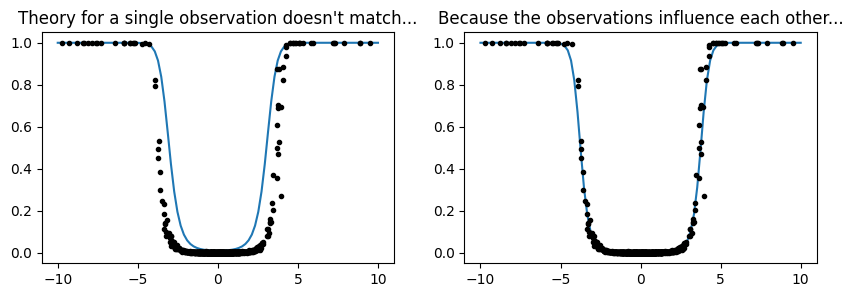

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,3))

bounds = np.abs(y)<10

ax[0].plot(support, (Pr_M_u_1_/(Pr_M_u_1_+Pr_M_u_0_)), label="$\\Pr(M[u_i=0]|y_i)$")
ax[0].plot(y[bounds],
           idata.posterior['spike'].values.reshape(c*d,t).mean(axis=0)[bounds],'k.');
ax[0].set_title("Theory for a single observation doesn't match...")

ax[1].plot(support, (.08*Pr_M_u_1_/(.08*Pr_M_u_1_+.92*Pr_M_u_0_)), label="$\\Pr(M[u_i=0]|y_i)$")
ax[1].plot(y[bounds],
           idata.posterior['spike'].values.reshape(c*d,t).mean(axis=0)[bounds],'k.');
ax[1].set_title("Because the observations influence each other...");


### Mixture Models

A very simple form of information sharing...

$$\scriptsize
\begin{align*}
x_i \sim {} & \sum_{k=1}^K \mathbf{v}_{ik} \mathcal N (\mu_k,\sigma_k^2) & \mu_k \sim {} & \mathcal N (\mu_{k0},\sigma_{k0}^2) \quad \sigma_k^2 \sim \text{Inverse-Gamma} (\alpha_{k0}, \beta_{k0})\\
\overset{\overset{\text{multinomial}}{\mathbf{v}_i\,\sim\,\text{MN}}(\mathbf{p}, \,n=1)}{\Pr(\mathbf{v}_i|E[\mathbf{v}_i]=\mathbf{p}, n=1)} = {}& \frac{n!}{v_1!\cdots v_K!} p_1^{\mathbf{v}_{i1}} \cdots p_K^{\mathbf{v}_{iK}}  & \sum_{j=1}^n \mathbf{v}_{ik} = {}& 1 \quad \mathbf{v}_{ik} \in \{0,1\} \quad \text{latent (unknown) subpulation membership $\textbf{v}$} \\
\underset{\text{Dirichlet}}{\overset{p\,\sim\,\text{Dir}(\boldsymbol \alpha)}{p\left(\mathbf{p}|\boldsymbol \alpha \right)}} = {}& {\frac {1}{\mathrm {B} ({\boldsymbol {\alpha }})}}\prod _{k=1}^{K}p_{k}^{\alpha _{k}-1} & \sum_{j=1}^np_k = {}& 1 \quad {\displaystyle \mathrm {B} ({\boldsymbol {\alpha }})= \prod \limits _{k=1}^{K}\Gamma (\alpha _{k}) \bigg/ \Gamma \left(\sum \limits _{k=1}^{K}\alpha _{k}\right)} \quad E[p_k] = \alpha_k\bigg/\sum_{k=1}^K \alpha_k
\end{align*}$$

$$\scriptsize
\begin{align*}
p(\mu_k | -) \propto {} & \mathcal N (\mu_k| \mu_{k0},\sigma_{k0}^2) \prod_{i=1}^n \sum_{k=1}^K\mathbf{v}_{ik} \mathcal N (x_i | \mu_k,\sigma_k^2) & p(\sigma_k^2 | -) \propto {} & \underset{\text{Inverse-Gamma}}{\text{IG} (\sigma_k^2|\alpha_{k0}, \beta_{k0})} \prod_{i=1}^n \sum_{k=1}^K\mathbf{v}_{ik} \mathcal N (x_i|\mu_k,\sigma_k^2)
\end{align*}$$$$\scriptsize
\begin{align*}
\Pr(\mathbf{v}_{ik}=1|-) \propto {} & p_1^{\mathbf{v}_{i1}} \cdots p_K^{\mathbf{v}_{iK}} \sum_{k=1}^K\mathbf{v}_{ik} \mathcal N (x_i | \mu_k,\sigma_k^2) & p(\mathbf{p}| - ) \propto {}& \prod _{k=1}^{K}p_{k}^{\alpha _{k}-1} \prod_{i=1}^{n} p_1^{\mathbf{v}_{i1}} \cdots p_K^{\mathbf{v}_{iK}}
\end{align*}$$

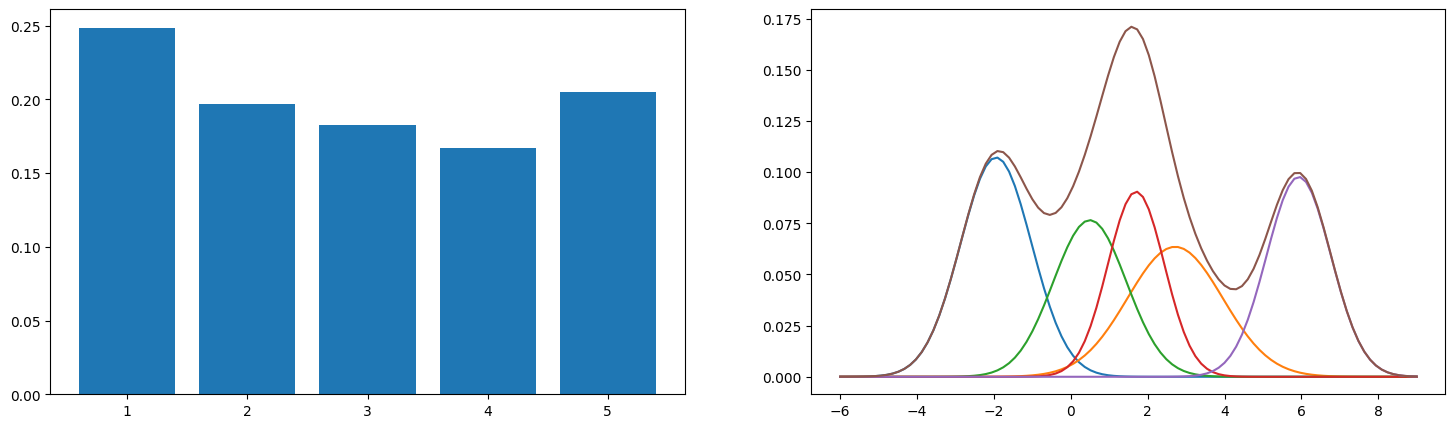

In [ ]:
np.random.seed(9)

k = 5
alpha = [2]*k
p_true = stats.dirichlet(alpha).rvs(1)[0] # p_true.sum() # 1

mu_k_true = stats.norm(0,3).rvs(k)
support = np.linspace(-6,9,100)
population_pdf = 0*support
sigma2_k_true = stats.halfnorm().rvs(k)

fig,ax = plt.subplots(1,2,figsize=(18,5))
ax[0].bar(x=np.linspace(1,5,5), height=p_true)
for j in range(k):
    subpopulation_pdf = p_true[j]*stats.norm(mu_k_true[j],sigma2_k_true[j]**0.5).pdf(support)
    ax[1].plot(support, subpopulation_pdf); population_pdf += subpopulation_pdf

ax[1].plot(support, population_pdf);

In [ ]:
n_ = 1000
v_true = stats.multinomial(n=1,p=p_true).rvs(n_)
v_true[:3,:]

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]])

In [ ]:
print(mu_k_true)
print((v_true*mu_k_true)[:3,:])
print((v_true*mu_k_true).sum(axis=1)[:3])

[-1.94384238  2.715657    0.49645017  1.70025387  5.93193509]
[[-1.94384238  0.          0.          0.          0.        ]
 [-1.94384238  0.          0.          0.          0.        ]
 [-0.          0.          0.49645017  0.          0.        ]]
[-1.94384238 -1.94384238  0.49645017]


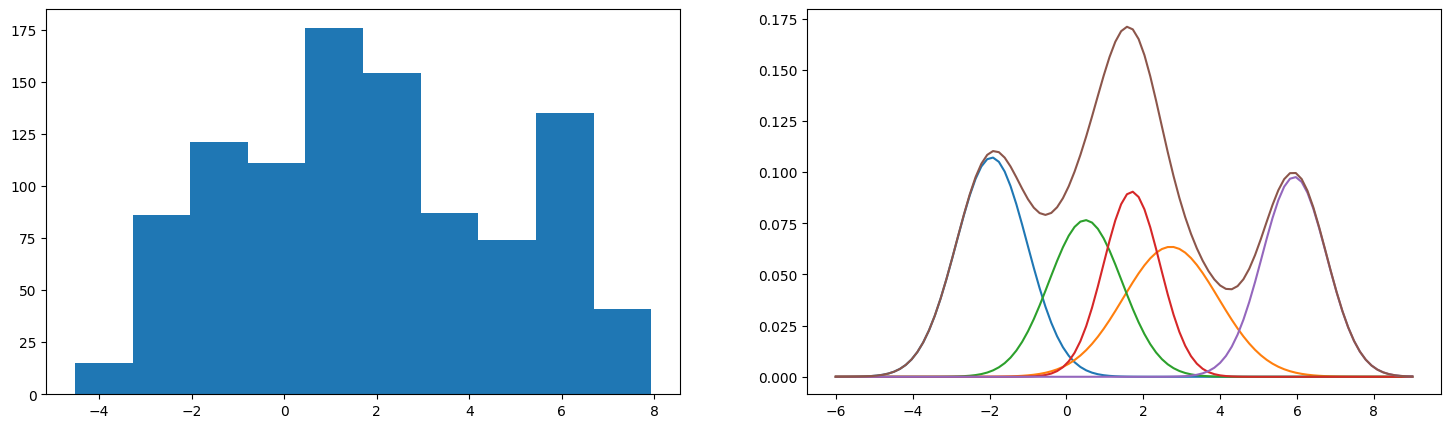

In [ ]:
x_ = stats.norm((v_true*mu_k_true).sum(axis=1), (v_true*sigma2_k_true).sum(axis=1)**0.5).rvs()
ax[0].hist(x_)
fig

### Hierachical (more than random effects) Models

A more interesting form of information sharing...


In [ ]:
n = 100
mu = np.sort(stats.norm(0,1).rvs(n))
r = 5
# create correlated observations
y = stats.norm(mu,1).rvs((r,n))
ndx = y.astype(int)
for j in range(100):
    ndx[:,j] = j

np.round(np.corrcoef(y),2)


array([[1.  , 0.46, 0.51, 0.45, 0.57],
       [0.46, 1.  , 0.45, 0.48, 0.44],
       [0.51, 0.45, 1.  , 0.43, 0.55],
       [0.45, 0.48, 0.43, 1.  , 0.51],
       [0.57, 0.44, 0.55, 0.51, 1.  ]])

In [ ]:
# Decorrelation by within group estimation
# with independent priors
with pm.Model() as MixEff:

    m = pm.Normal('m', mu=0, sigma=10, shape=n)
    s = pm.HalfNormal('s', sigma=10, shape=n)

    x = pm.Normal('x', mu=m[ndx.flatten()],
                       sigma=s[ndx.flatten()],
                  observed=y.flatten())

    idata = pm.sample()

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.23        15           340.02 draws/s   0:00:05   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.24        15           187.42 draws/s   0:00:10   0:00:00

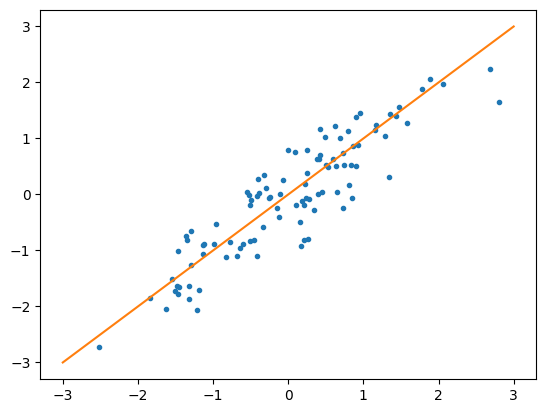

In [ ]:
c,d = idata.posterior.m.shape[:2]
plt.plot(mu, idata.posterior.m.values.reshape(c*d,n).mean(axis=0), '.')
plt.plot([-3,3],[-3,3]);


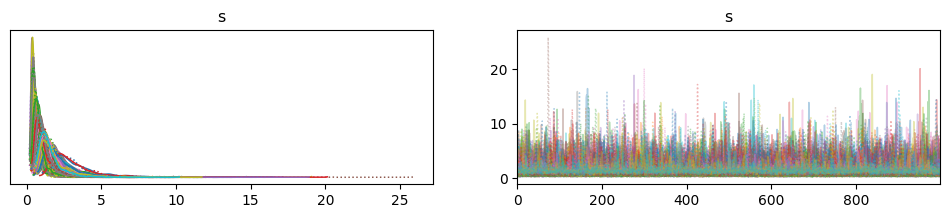

In [ ]:
az.plot_trace(idata, var_names='s');

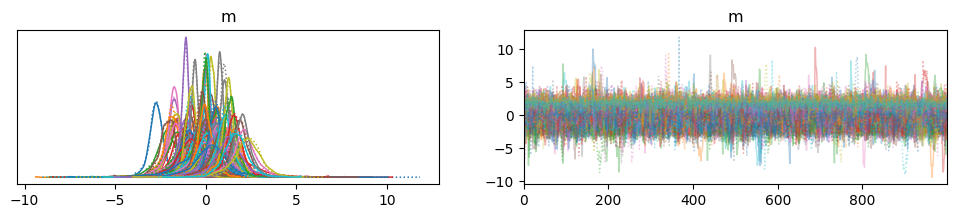

In [ ]:
az.plot_trace(idata, var_names='m');

In [ ]:
# Decorrelation by within group estimation
# with common hierarchical priors
with pm.Model() as MixEff2:

    m_s = pm.HalfNormal('m_s', sigma=10)
    m_ = pm.Normal('m_', mu=0, sigma=m_s)
    m = pm.Normal('m', mu=m_, sigma=m_s, shape=n)

    s_s = pm.HalfNormal('alpha', sigma=10)
    s_ = pm.HalfNormal('beta', sigma=10)
    s = pm.Gamma('s', alpha=s_s, beta=s_, shape=n)

    x = pm.Normal('x', mu=m[ndx.flatten()], sigma=s[ndx.flatten()],
                  observed=y.flatten())

    idata2 = pm.sample()


0.8337212735494165 0.3061846381399181


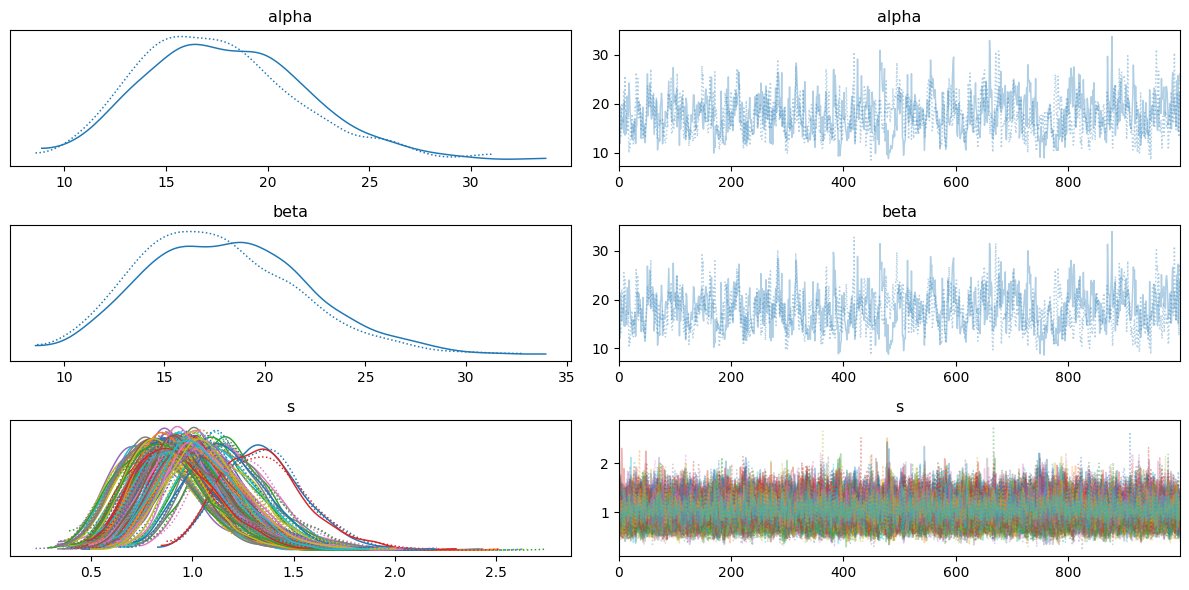

In [21]:
az.plot_trace(idata2, var_names=['alpha','beta','s'])
plt.tight_layout()
print(y.std(axis=0).mean(),y.std(axis=0).std())

-0.041950708274232446 1.0559396983972693


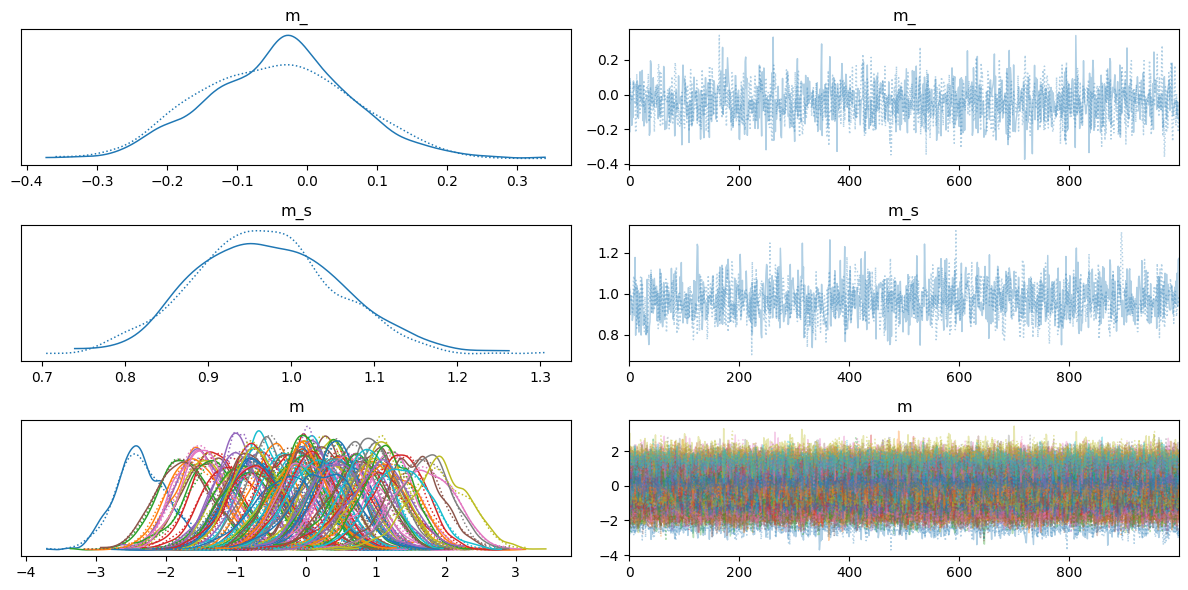

In [22]:
az.plot_trace(idata2, var_names=['m_','m_s','m'])
plt.tight_layout()
print(y.mean(axis=0).mean(),y.mean(axis=0).std())

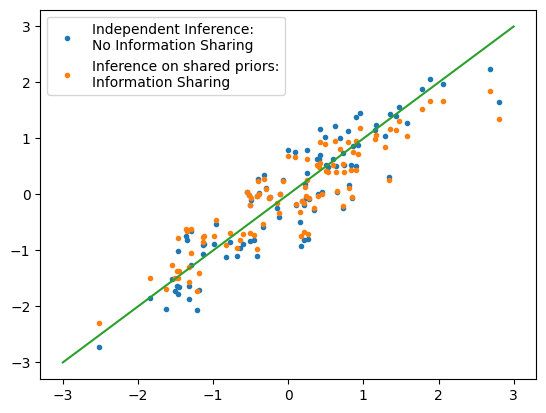

In [23]:
c,d = idata2.posterior.m.shape[:2]
plt.plot(mu, idata.posterior.m.values.reshape(c*d,n).mean(axis=0),
         '.', label="Independent Inference:\nNo Information Sharing")
plt.plot(mu, idata2.posterior.m.values.reshape(c*d,n).mean(axis=0),
         '.', label="Inference on shared priors:\nInformation Sharing")
plt.plot([-3,3],[-3,3])
plt.legend();

In [24]:
((mu-idata.posterior.m.values.reshape(c*d,n).mean(axis=0))**2).sum()**0.5

np.float64(4.632418295031809)

In [25]:
((mu-idata2.posterior.m.values.reshape(c*d,n).mean(axis=0))**2).sum()**0.5

np.float64(4.477859987985188)

In [26]:
# What we've learned
with pm.Model() as MixEff3:

    m = pm.Normal('m', mu=0, sigma=1, shape=n)
    s = pm.Gamma('s', alpha=16,beta=16, shape=n)

    x = pm.Normal('x', mu=m[ndx.flatten()], sigma=s[ndx.flatten()],
                  observed=y.flatten())

    idata3 = pm.sample()

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.34        15           463.49 draws/s   0:00:04   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.45        15           216.16 draws/s   0:00:09   0:00:00

In [ ]:
c,d = idata.posterior.m.shape[:2]
plt.plot(mu, idata3.posterior.m.values.reshape(c*d,n).mean(axis=0), '.')
plt.plot([-3,3],[-3,3]);


In [ ]:
((mu-idata3.posterior.m.values.reshape(c*d,n).mean(axis=0))**2).sum()**0.5

In [ ]:
# Something hacky just to show more information sharing
with pm.Model() as MixEff4:

    m = pm.Normal('m', mu=0, sigma=1, shape=n+4)
    s = pm.Gamma('s', alpha=16,beta=16, shape=n+4)

    x = pm.Normal('x', mu=(m[ndx.flatten()]+m[ndx.flatten()+1]+m[ndx.flatten()+2]+m[ndx.flatten()+3]+m[ndx.flatten()+4])/5,
                       sigma=(s[ndx.flatten()]+s[ndx.flatten()+1]+s[ndx.flatten()+2]+s[ndx.flatten()+3]+s[ndx.flatten()+4])/5,
                  observed=y.flatten())

    idata4 = pm.sample()

In [ ]:
az.plot_trace(idata4, var_names=['m','s'])
plt.tight_layout()
print(y.mean(axis=0).mean(),y.mean(axis=0).std())

In [ ]:
idata2.posterior['m'].values.reshape(c*d,n).std(axis=0)

In [32]:
((idata4.posterior['m'].values[:,:,:-4]+
  idata4.posterior['m'].values[:,:,1:-3]+
  idata4.posterior['m'].values[:,:,2:-2]+
  idata4.posterior['m'].values[:,:,3:-1]+
  idata4.posterior['m'].values[:,:,4:])/5).reshape(c*d,n).std(axis=0)

array([0.29417235, 0.2494004 , 0.23808297, 0.23329469, 0.24317065,
       0.24375901, 0.24146519, 0.23881791, 0.24545573, 0.24538845,
       0.24950997, 0.25134674, 0.25336485, 0.24427875, 0.24145902,
       0.24486769, 0.24872199, 0.23857415, 0.24004712, 0.23682014,
       0.23627895, 0.23828377, 0.23782798, 0.23741615, 0.23721729,
       0.24275622, 0.24626767, 0.24827367, 0.24321349, 0.24746822,
       0.24476471, 0.24545879, 0.24258472, 0.23971659, 0.2396787 ,
       0.22984907, 0.22860583, 0.22664786, 0.22360756, 0.23862544,
       0.22818621, 0.22243173, 0.23401441, 0.2357814 , 0.23784257,
       0.24293754, 0.24137066, 0.24921553, 0.24663744, 0.24335526,
       0.25082462, 0.24517902, 0.25007522, 0.25113933, 0.24175149,
       0.24455553, 0.24928965, 0.26111444, 0.26216395, 0.25677898,
       0.24726863, 0.24152113, 0.2302724 , 0.23137471, 0.23581013,
       0.23814163, 0.24592454, 0.24294725, 0.24229577, 0.2396234 ,
       0.2399002 , 0.23726938, 0.23357403, 0.23929894, 0.24149

In [ ]:
mmm = \
((idata4.posterior['m'].values[:,:,:-4]+
  idata4.posterior['m'].values[:,:,1:-3]+
  idata4.posterior['m'].values[:,:,2:-2]+
  idata4.posterior['m'].values[:,:,3:-1]+
  idata4.posterior['m'].values[:,:,4:])/5).reshape(c*d,n).mean(axis=0)

In [ ]:
c,d = idata.posterior.m.shape[:2]
plt.plot(mu, mmm, '.')
plt.plot([-3,3],[-3,3]);


In [ ]:
((mu-mmm)**2).sum()**0.5

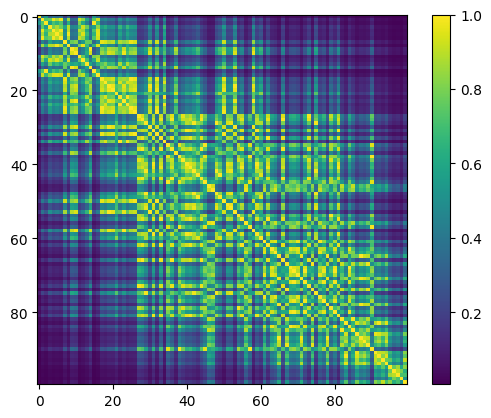

In [36]:
_lambda = .06
sigma2 = 1
K = sigma2*np.exp(-(y.mean(axis=0).reshape(n,1) -
                    y.mean(axis=0).reshape(1,n))**2/_lambda**2)

alf = 1
K = sigma2*np.exp(-alf*np.abs(y.mean(axis=0).reshape(n,1) -
                              y.mean(axis=0).reshape(1,n)))

K=(K+K.T)/2  # np.linalg.matrix_rank(K)
plt.imshow(K)
plt.colorbar();

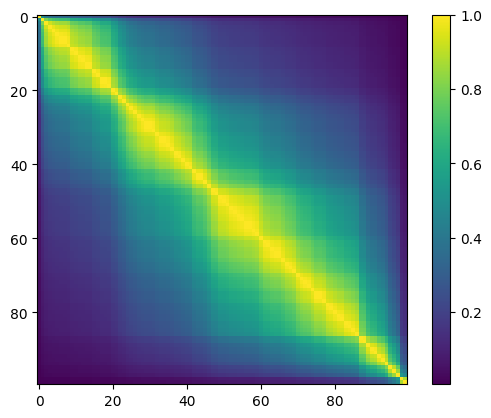

In [37]:
K = sigma2*np.exp(-alf*np.abs(mu.reshape(n,1) -
                              mu.reshape(1,n)))
K=(K+K.T)/2  # np.linalg.matrix_rank(K)
plt.imshow(K)
plt.colorbar();

In [38]:
# What we've learned
with pm.Model() as MixEff5:

    m = pm.MvNormal('m', mu=0, cov=K, initval=y.mean(axis=0))
    s = pm.Gamma('s', alpha=16, beta=16, shape=n)
    x = pm.Normal('x', mu=m[ndx.flatten()], sigma=s[ndx.flatten()],
                  observed=y.flatten())

    idata5 = pm.sample()

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.14        31           105.40 draws/s   0:00:18   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.14        31           53.05 draws/s    0:00:37   0:00:00

In [ ]:
c,d = idata.posterior.m.shape[:2]
plt.plot(mu, idata5.posterior.m.values.reshape(c*d,n).mean(axis=0), '.')
plt.plot([-3,3],[-3,3]);


In [ ]:
az.plot_trace(idata5, var_names=['m','s'])
plt.tight_layout()
print(y.mean(axis=0).mean(),y.mean(axis=0).std())

In [ ]:
((mu-idata5.posterior.m.values.reshape(c*d,n).mean(axis=0))**2).sum()**0.5

In [ ]:
plt.plot(mu, label="truth")
plt.plot(y.mean(axis=0), label="observed")
plt.plot(np.sort(y.mean(axis=0)), label="rank")
plt.legend();

In [ ]:
K = sigma2*np.exp(-alf*np.abs(np.sort(y).mean(axis=0).reshape(n,1) -
                              np.sort(y).mean(axis=0).reshape(1,n)))

K=(K+K.T)/2  # np.linalg.matrix_rank(K)
plt.imshow(K)
plt.colorbar();

In [ ]:
# What we've learned
with pm.Model() as MixEff6:

    m = pm.MvNormal('m', mu=0, cov=K, initval=y.mean(axis=0))
    s = pm.Gamma('s', alpha=16, beta=16, shape=n)
    x = pm.Normal('x', mu=m[ndx.flatten()], sigma=s[ndx.flatten()],
                  observed=y[:,np.argsort(y.mean(axis=0))].flatten())

    idata6 = pm.sample()

In [ ]:
c,d = idata.posterior.m.shape[:2]
plt.plot(mu, idata6.posterior.m.values.reshape(c*d,n).mean(axis=0), '.')
plt.plot([-3,3],[-3,3]);


In [ ]:
((mu-idata6.posterior.m.values.reshape(c*d,n).mean(axis=0))**2).sum()**0.5

## Back to Model Selection

### LRT

The **(nested) log likelihood ratio test (LRT) statistic** is $\quad2\log\left(\frac{p(y|\hat \theta_{M_1})}{p(y|\hat \theta_{M_0)}}\right) = \color{gray}{2(\log(p(y|\hat \theta_{M_1})) - \log(p(y|\hat \theta_{M_0})))} $

and has an asymptotically $\;\chi^2_{df}\;$ distribution with **expected value** [equal](https://en.wikipedia.org/wiki/Likelihood-ratio_test) **degrees of freedom**  $\dim(\theta_{M_1})-\dim(\theta_{M_0})$

$$2\log\left(\frac{p(y|X_{n\times p}\hat \beta)}{p(y|\bar y)}\right)\quad \text{is asymptotically} \;\;\chi^2_{p-1}\;\;\text{and a large LRT statistic rejects $M_0$ in favor of $M_1$} $$

> #### Sketch of Some "Intuition" as to Why this is so
>
> - $p(y|\hat \theta_{M})$ is assymptotically normal
> - $\frac{p(y|\hat \theta_{M_1})}{p(y|\hat \theta_{M_0})}$ cancels normalizing constants
> - $\log p(y|\hat \theta_{M})$ after canceling normalizing constants, and since one parameter $\theta_i$ perfectly predicts one $\theta_i=y_i$, is $-\frac{1}{2}\sum_{i=1}^{n-\text{dim}(M)+1} \frac{(y_i-\bar y)^2}{\sigma^2} -\frac{1}{2}\sum_{i=1}^{\text{dim}(M)-1} \frac{(y_j-y_j)^2}{\sigma^2}$
> - $E[\frac{(y_i-\bar y)^2}{\sigma^2}] = 1$ so the $-\frac{1}{2}$ term makes difference $\text{dim}(M)-1$ and cancels the scaling $2$

### Deviance  and "Bayesian" Model Size

Model **deviance** is $\quad D(\theta) = 2(\underset{\text{a constant}}{\overset{\text{saturated model}}{\log(p(y|y))}} - \overset{\text{actual model}}{\log(p(y|\theta)})) \color{gray}{= 2\log\left(\frac{p(y|y)}{p(y|\theta)}\right)} \geq 0 \quad$ (scaled by $2$ [to match the LR](https://stats.stackexchange.com/qu,estions/379810/why-is-the-deviance-defined-with-a-factor-2-or-likelihood-ratio-squared))

The [Bayesian characterization](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=d78ad2497639bff740d0c1181c35263d2630b172)
 of the **effective number of parameters** in a model is

$$p_D = {\overline{D(\theta)} - D(\bar{\theta})} \color{gray}{= 2(\log(p(y|\bar{\theta})) - \overline{\log(p(y|\theta))}) \underset{\text{usually}}{\geq 0}} \quad \text{ or } \quad \underset{\text{not typically preferred as it's less stable}}{p_D = 2\text{Var}_{p(\theta|y)}[\log(p(y|\theta))]}$$

because (for fixed models such as ["linear models with uniform prior distributions"](http://www.stat.columbia.edu/~gelman/research/published/waic_understand3.pdf) and large $n$) both versions of $p_D$ estimate the degrees of freedom parameter of the asymptotic $\chi^2_{\text{df}}$ of $\log(p(y|\theta))$ which is the number of parameters $p(y|\theta)$.

> #### Sketch of the "Proof" as to Why this is so
>
> $-2\log(p(y|\bar{\theta})$ for linear regression is the expected standardized residual sum of squares
>
> $\begin{align*}
(y-\hat y)^T(y-\hat y)/\sigma^2 &={} y^T(I-H)^T(I-H)y/\sigma^2
= y^T(I-H)(I-H)y/\sigma^2
= y^T(I-H)y/\sigma^2 \\
&={} (X\beta + \epsilon)^T(I-H)(X\beta + \epsilon)/\sigma^2
= \epsilon^T(I-H)\epsilon/\sigma^2 = \text{trace}(\epsilon^T(I-H)\epsilon/\sigma^2)\\
&={} \text{trace}((I-H)\epsilon\epsilon^T/\sigma^2) = \text{trace}((I-H)\epsilon\epsilon^T/\sigma^2) \\
\text{with expected value} & \quad \; \text{trace}((I-H)\sigma^2I/\sigma^2) = \text{trace}(I-H) = n - \text{trace}(H)\\
&={} n - \text{trace}(X^T(X^TX)^{-1}X) = n - \text{trace}((X^TX)^{-1}XX^T) = n - \text{trace}(I_{p \times p})\\
&={} n - p
\end{align*}$
>
> while $-2\overline{\log(p(y|\theta))}$ does something like reflect the variability of $n-p$ unexplained data points plus the variability of $p$ parameters
> $E_{\hat y}[\sum_{i=1}^n \frac{(y_i - \hat y_i)^2}{\sigma^2} ] \overset{\text{if unbiased}}{\approx} E_{\hat y}[\sum_{i=1}^n \frac{(y_i - E[y_i])^2}{\sigma^2} ]$ which has an expected value (with respect to $y$) of $n$.

### Information Criterion

**Information Criterion** criterion refer to the fact that each additional parameter is expected to decrease $-2\log f(y | \theta)$ by $1$ unit, where a lower negative loglikelihood is "better".

Rearranging $\;\;p_D = {\overline{D(\theta)} - D(\bar{\theta})}\;\;$ in terms of **posterior mean deviance** $\;\;\overline{D(\theta)} = D(\bar{\theta}) + p_D\;\;$ leads to the ["adequacy" "measure of fit plus complexity"](https://fisher.stats.uwo.ca/faculty/aim/2015/9938/articles/SpiegelhalterJRSSB2002.pdf) **deviance information criterion** in the standard **information criterion form**

\begin{align*}
\text{DIC:} \;{}& -2\log(p(y|\bar{\theta})) + 2p_D \quad\;\;\text{since} \quad \overline{D(\theta)}+p_D = D(\bar{\theta}) + 2p_D \quad \text{$p(y|y)$'s cancel in DIC$_{M_1}$-DIC$_{M_0}$}\\
\text{AIC:} \;{}& -2\log(p(y|\hat{\theta})) + 2p \quad\quad\, \text{and $\quad e^{(\text{AIC$_{M_0}$-AIC$_{M_1}$})/2}\quad$ is an unnested version of the }\textbf{LRT statistic}\\
\text{BIC:} \;{}& -2\log(p(y|\hat{\theta})) + p\ln(n) \;\;\, \text{which approximates }\textbf{Bayes Factor} K = \frac{p(\mathbf{x}|M_1)}{p(\mathbf{x}|M_0)} \approx e^{(BIC_{M_0}-BIC_{M_1})/2}
\end{align*}

### Out of sample predictive performance

Recall that **Bayes factors** induce an **Occam's razor** (parameter integration dimension) penalization for model complexity; whereas, **DIC** and [**AIC**](https://stats.stackexchange.com/questions/116935/comparing-non-nested-models-with-aic) measure ["out-of-sample-prediction error using a bias-corrected adjustment of within-sample error"](http://www.stat.columbia.edu/~gelman/research/published/waic_understand3.pdf)

Even though the **Bayesian Occam's razor** (with **Bayes factors**) naturally favoring parsimony in model selection is intuitively attractive, this "simplest solution is the best solution" perspective is not necessarily always justified.

- It is still reasonable to prefer more complex models with improved out of sample performance

**Machine learning $K$-folds cross-validation parameter tuning** optimizes the *bias-variance tradeoff** in a model fit which allows the model to be both underfit and overfit in different areas of the prediction space and so improves the overall out of sample predictive accuracy by reducing bias in critical areas while inducing minimal "collatoral damage" from overfitting in other areas.

- **Bayesian Occam's razor** (with **Bayes factors**) does not attempt to optimize the **bias-variance tradeoff** in this "overfitting" manner; rather, it penalizes "prior misspecifications" that are increasingly unavoidable in higher dimensions and can rapidly overwhelm the potential beneficial increases in model flexibility observable in the likelihood.


### Widely Applicable Information Criterion (WAIC)<br> and Leave-One-Out Cross Validation (LOO-CV)

- ***BIC:*** $\;-2\log(p(y|\hat{\theta})) + p \ln(n)\;$ is based on approximating ***Bayes factors***
    - but it's not actualy a **Bayesian** method since it doesn't integrate over the **posterior uncertainty**
- **DIC:** $\;-2\log(p(y|\bar{\theta})) + 2p_D\;$ is similarly not **fully Bayesian**
    - since $p_D \color{gray}{= {\overline{D(\theta)} - D(\bar{\theta})}} = \color{navy}{2(\log(p(y|\bar{\theta})) - \overline{\log(p(y|\theta))})}$
    - **conditions** on the **posterior mean** $\bar{\theta}$ rather than integrating over the **posterior uncertainty**(!)
    - The alternative $\color{purple}{\;p_D = 2\text{Var}_{p(\theta|y)}[\log(p(y|\theta))]\;}$ was unstable but it was **fully Bayesian**...

**WAIC** uses the **log pointwise predictive density** $llpd = \log\left(\prod_{i=1}^n p(y_i|\theta)\right)$ to estimate **effective model size** as

$$\color{purple}{\;p_{\text{WAIC2}} = \sum_{i=1}^n\text{Var}_{p(\theta|y)}[\log(p(y_i|\theta))]\quad \color{gray}{\text{(although note there's no longer a factor of $2$ [proof not shown])}}}$$
which provide stable estimation, and is preferred over the (also **fully Bayeisan**) $$\;\color{navy}{p_{\text{WAIC1}} = 2\sum_{i=1}^n\left(\log\left( \frac{1}{T}\sum_{t=1}^T p(y_i|\theta^{(t)}) \right) - \frac{1}{T}\sum_{t=1}^T\log(p(y_i|\theta^{(t)}))\right)\;}$$ because $p_{\text{WAIC2}}$ <u>is theoretically and empirically more similar to a **LOO-CV**</u> calculation than $p_{\text{WAIC1}}$ <font style='color:gray'></font>


The above **information criterion** can now be extended with

$\quad\quad\text{WAIC:} \;-2\sum_{i=1}^n\left(\log\overline{p(y_i|\theta)}\right) + 2p_{\text{WAIC2}} =  -2\sum_{i=1}^n\left(\log\left( \frac{1}{T}\sum_{t=1}^T p(y_i|\theta^{(t)}) \right)\right) + 2p_{\text{WAIC2}}$

---

The difference bewteen **WAIC** and **DIC** is that **WAIC** fully integrates over the posterior while **DIC** does not and instead conditions on the **posterior parameter mean**

- They both are "more Bayesian" than the **AIC** in incorporate the **prior** into **effective model size** estimation
- and in the same way both are "more Bayesian" than the **BIC** even though it approximates **Bayes factors**

> <font style='color:navy'>And anyway remember that **BIC** does not estimate ["out-of-sample-prediction error using a bias-corrected adjustment of within-sample error"](http://www.stat.columbia.edu/~gelman/research/published/waic_understand3.pdf)</font>


But ***WAIC*** is just a computationally tractable alternative to  
***bias corrected <u>log pointwise predictive density</u> $lppd$ Leave-One-Out Cross Validation (LOO-CV)***

$$\overset{\text{corrected}}{lppd_{loo-cv}}=\sum_{i=1}^n\log \underbrace{\left(\frac{1}{T}\sum_{t=1}^T p(y_i|\theta^{(t|-i)})\right)}_{\theta^{(t|-i)} \sim p(\theta|y_{-i})} + \underset{\text{due to using $n-1$ not $n$}}{\underbrace{lppd-\overline{lppd^{(-i)}}}_{\text{underestimated accuracy}}}$$

with ***AIC***, ***DIC*** and ***WAIC*** are asymptotically equivalent to ***log pointwise predictive density LOO-CV*** under various conditions...


## Week 11 Homework (9)

Completed with the help of Claude.

### Q1: copulas

1. ~~Use the example copula code below to provide posterior inference on the dependency structure between for **your own non normally distributed data that you find**~~
2. Repeat the exercise using instead a two pass approach in the manner of https://www.pymc.io/projects/examples/en/latest/howto/copula-estimation.html
3. Describe what a copula is and how the two verions of code implement it
4. Describe how to use this to create arbitrary multivariate GLM regressions

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

p = 3
#Psi = np.eye(p)
#a_cov = stats.invwishart(df=p+2, scale=Psi).rvs()
a_cor = (np.ones((p,p))*9+np.diag((1,1,1)))/10
a_cor[0,-1] -= 0.15
a_cor[-1,0] -= 0.15

n = 100
x = stats.multivariate_normal(mean=np.zeros(p), cov=a_cor).rvs(size=n)
plt.imshow(a_cor)
plt.colorbar();


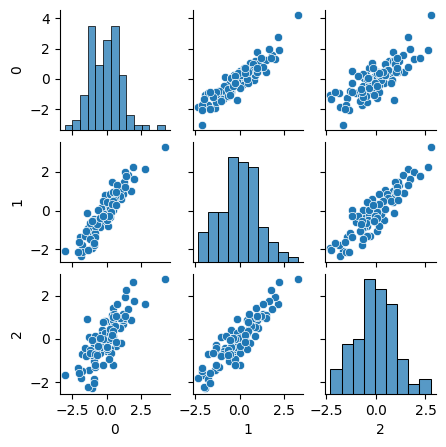

In [48]:
import seaborn
import pandas as pd
seaborn.pairplot(pd.DataFrame(x),height=1.5);

In [ ]:
y = x.copy()
y[:,0] = stats.gamma(a=5).ppf(stats.norm().cdf(x[:,0]))
y[:,1] = stats.expon(scale=1).ppf(stats.norm().cdf(x[:,1]))
y[:,2] = stats.chi2(df=10).ppf(stats.norm().cdf(x[:,2]))

seaborn.pairplot(pd.DataFrame(y),height=1.5);

In [ ]:
# import pymc as pm
# import arviz as az

# with pm.Model() as copula:

#     p0 = pm.HalfNormal('p0', sigma=10)
#     y0 = pm.Gamma('y0', alpha=p0, beta=1, observed=y[:,0:1])
#     y0_ = pm.Deterministic('y0_',
#             pm.Normal.icdf(
#                pm.math.exp(pm.Gamma.logcdf(y0, alpha=p0, scale=1)),
#                            mu=0, sigma=1))

#     p1 = pm.HalfNormal('p1', sigma=10)
#     y1 = pm.Exponential('y1', lam=p1, observed=y[:,1:2])
#     y1_ = pm.Deterministic('y1_',
#             pm.Normal.icdf(
#                pm.math.exp(pm.Exponential.logcdf(y1, lam=p1)),  # Changed mu to lam for Exponential.logcdf
#                            mu=0, sigma=1))

#     p2 = pm.HalfNormal('p2', sigma=10)
#     y2 = pm.ChiSquared('y2', nu=p2, observed=y[:,2:3])
#     y2_ = pm.Deterministic('y2_',
#             pm.Normal.icdf(
#                pm.math.exp(pm.ChiSquared.logcdf(y2, nu=p2)),
#                            mu=0, sigma=1))

#     L,R,stds = pm.LKJCholeskyCov("R", n=3, eta=2.0,
#                                  sd_dist=pm.Exponential.dist(1.0, shape=3),
#                                  compute_corr=True)

#     potential = pm.Potential("MVNeval",
#                              pm.logp(pm.MvNormal.dist(mu=0, cov=R),
#                              pm.math.concatenate([y0_,y1_,y2_], axis=1)))

#     idata = pm.sample()

# # This probally produces a lot of warnings but it will run and provide inference

In [ ]:
# Estimation is essentially correct
az.plot_trace(idata, var_names=['p0','p1','p2'])
plt.tight_layout()

In [ ]:
# Estimation is essentially correct
fig,ax = plt.subplots(1,4,figsize=(10,2))
for i,c in enumerate(list(idata.posterior['R_corr'].values.mean(axis=1))):
    ax[i].imshow(c)
    for k in range(3):
        for j in range(3):
            ax[i].text(j,k,s=str(round(c[j,k],3)),
                       color='w', va='center', ha='center')

### **Solution:**

## 1. Two-Pass Approach for Copula Estimation

To implement a two-pass approach for copula estimation (following the PyMC example), I would modify the given code as follows:

In [ ]:
import numpy as np
import pymc as pm
import arviz as az
from scipy import stats

# FIRST PASS: Estimate marginal distributions separately
with pm.Model() as marginal_model0:
    p0 = pm.HalfNormal('p0', sigma=10)
    y0 = pm.Gamma('y0', alpha=p0, beta=1, observed=y[:,0])
    trace0 = pm.sample()

with pm.Model() as marginal_model1:
    p1 = pm.HalfNormal('p1', sigma=10)
    y1 = pm.Exponential('y1', lam=p1, observed=y[:,1])
    trace1 = pm.sample()

with pm.Model() as marginal_model2:
    p2 = pm.HalfNormal('p2', sigma=10)
    y2 = pm.ChiSquared('y2', nu=p2, observed=y[:,2])
    trace2 = pm.sample()

# Get posterior means for parameters
p0_mean = az.summary(trace0)['mean']['p0']
p1_mean = az.summary(trace1)['mean']['p1']
p2_mean = az.summary(trace2)['mean']['p2']

# SECOND PASS: Transform data to normal space using estimated parameters
u0 = pm.Gamma.cdf(y[:,0], alpha=p0_mean, beta=1)
u1 = pm.Exponential.cdf(y[:,1], lam=p1_mean)
u2 = pm.ChiSquared.cdf(y[:,2], nu=p2_mean)

# Apply inverse normal CDF to get normal scores
z0 = stats.norm.ppf(u0)
z1 = stats.norm.ppf(u1)
z2 = stats.norm.ppf(u2)
z = np.column_stack([z0, z1, z2])

# Estimate correlation of transformed data
with pm.Model() as correlation_model:
    L, R, _ = pm.LKJCholeskyCov("R", n=3, eta=2.0,
                             sd_dist=pm.Exponential.dist(1.0, shape=3),
                             compute_corr=True)
    pm.MvNormal('mvn', mu=np.zeros(3), chol=L, observed=z)
    correlation_trace = pm.sample()

## 2. What is a Copula and How the Two Versions Implement It

A copula is a mathematical function that decouples the dependency structure of a multivariate distribution from its marginal distributions. Based on Sklar's theorem, any multivariate distribution can be decomposed into:
1. Its marginal distributions
2. A copula that describes the dependency structure

Mathematically, if F is a multivariate CDF with marginals F₁,...,Fₙ, then there exists a copula function C such that:
F(x₁,...,xₙ) = C(F₁(x₁),...,Fₙ(xₙ))

The two implementations differ in their approach:

**One-Pass Approach (Original Code):**
- Simultaneously estimates both marginal distribution parameters and dependency structure
- Uses a potential function to connect the transformed variables in the normal space
- Models everything within a single Bayesian inference procedure
- More computationally intensive but potentially captures parameter uncertainty better

**Two-Pass Approach:**
- First estimates each marginal distribution separately
- Then transforms data to uniform space (via CDF) and normal space (via inverse normal CDF)
- Finally estimates the dependency structure using the transformed data
- More computationally efficient and often more numerically stable
- May not fully account for uncertainty in marginal parameters when estimating the dependency

Both approaches use a Gaussian copula, where dependency is modeled through a multivariate normal distribution after transforming variables to the normal space.

## 3. Creating Arbitrary Multivariate GLM Regressions with Copulas

To create arbitrary multivariate GLM regressions using copulas:

1. **Model each response variable separately with appropriate GLMs:**

In [ ]:
with pm.Model() as glm1:
       # Predictor variables and coefficients for first response
       beta1 = pm.Normal('beta1', mu=0, sigma=1, shape=num_predictors)
       mu1 = pm.math.dot(X, beta1)

       # Use appropriate link function and distribution (e.g., log link with Gamma)
       link1 = pm.math.exp(mu1)  # Log link
       y1 = pm.Gamma('y1', alpha=shape_param, beta=shape_param/link1, observed=data[:,0])

       # Compute and store CDF for later use in copula
       u1 = pm.Deterministic('u1', pm.Gamma.cdf(y1, alpha=shape_param, beta=shape_param/link1))

2. **Repeat for each response variable with appropriate distributions and link functions:**


In [ ]:
with the_model:
       # Second response (e.g., logit link with Bernoulli)
       beta2 = pm.Normal('beta2', mu=0, sigma=1, shape=num_predictors)
       mu2 = pm.math.dot(X, beta2)
       p2 = pm.math.invlogit(mu2)  # Logit link
       y2 = pm.Bernoulli('y2', p=p2, observed=data[:,1])
       u2 = pm.Deterministic('u2', pm.Bernoulli.cdf(y2, p=p2))

       # Third response (e.g., identity link with Normal)
       beta3 = pm.Normal('beta3', mu=0, sigma=1, shape=num_predictors)
       mu3 = pm.math.dot(X, beta3)
       y3 = pm.Normal('y3', mu=mu3, sigma=sigma, observed=data[:,2])
       u3 = pm.Deterministic('u3', pm.Normal.cdf(y3, mu=mu3, sigma=sigma))

3. **Connect all responses through a Gaussian copula:**

In [ ]:
with the_model:
       # Transform to normal space
       z1 = pm.Deterministic('z1', pm.math.normcdf(u1))
       z2 = pm.Deterministic('z2', pm.math.normcdf(u2))
       z3 = pm.Deterministic('z3', pm.math.normcdf(u3))

       # Specify correlation structure
       L, R, _ = pm.LKJCholeskyCov("R", n=3, eta=2.0, compute_corr=True)

       # Add potential to account for dependence
       z = pm.math.stack([z1, z2, z3], axis=1)
       pm.Potential("copula_potential", pm.logp(pm.MvNormal.dist(mu=0, chol=L), z))

This approach allows modeling responses with different distributions (Gamma, Bernoulli, Normal, etc.) while capturing their dependencies through the copula. The regression coefficients for each response variable can be different, letting you create truly flexible multivariate regression models.

The key advantage is that you're not constrained to using the same distribution for all response variables, as you would be in traditional multivariate regression approaches.

### Q2: Variable Selection using Spike and Slab

Perform multivarite regression (or multivariate probit classification) with spike and slab variable selection priors and compare inference to analagous inference with diffuse normal priors (imposing minimal L2 style regularization on the likelihood).

You may artificially limit the size of your data to reduce the computational demands, but if you do so, discuss the behavior of the computational demands with respect to the number of observations $n$, the number of random variables $m$ making up the multivariate observations, and the number of columns of the design matrix $p$.



### **Solution:**

# Multivariate Regression with Spike and Slab vs. Diffuse Normal Priors

I'll implement and compare multivariate regression with spike and slab priors versus diffuse normal priors, demonstrating their differences in variable selection and computational characteristics.

## Part 1: Implementing Both Approaches

Let's first create synthetic data with known true coefficients, where some predictors are truly informative and others are noise:

In [ ]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data
n = 100  # Number of observations
p = 10   # Number of predictors
m = 2    # Dimensions of response (multivariate)

# Create design matrix with correlated predictors
X = np.random.normal(0, 1, size=(n, p))
X[:, 1] = X[:, 0] * 0.3 + np.random.normal(0, 0.95, size=n)  # Correlated predictor

# True coefficients - only 4 out of 10 predictors are relevant
beta_true = np.zeros((p, m))
beta_true[0, 0] = 1.5   # Strong effect on first response
beta_true[2, 0] = -0.7  # Moderate effect on first response
beta_true[1, 1] = 1.0   # Effect only on second response
beta_true[5, 1] = 0.8   # Effect only on second response

# Generate response data with noise
Y = np.dot(X, beta_true) + np.random.normal(0, 0.5, size=(n, m))

# Display which coefficients are truly non-zero
print("True non-zero coefficients:")
for j in range(m):
    for i in range(p):
        if beta_true[i, j] != 0:
            print(f"Response {j+1}, Predictor {i+1}: {beta_true[i, j]}")

# Create standardized versions of X and Y for modeling
X_std = (X - X.mean(axis=0)) / X.std(axis=0)
Y_std = (Y - Y.mean(axis=0)) / Y.std(axis=0)

# --------------------------------
# Model 1: Spike and Slab Model
# --------------------------------
start_time_ss = time.time()

with pm.Model() as spike_slab_model:
    # Global inclusion probability
    phi = pm.Beta('phi', alpha=1, beta=1)

    # Coefficient priors for each response dimension
    for j in range(m):
        # Variable inclusion indicators
        gamma = pm.Bernoulli(f'gamma_{j}', p=phi, shape=p)

        # Spike and slab prior for coefficients
        # The "spike" is at zero (when gamma=0)
        # The "slab" is a normal distribution (when gamma=1)
        beta_raw = pm.Normal(f'beta_raw_{j}', mu=0, sigma=2, shape=p)
        beta = pm.Deterministic(f'beta_{j}', gamma * beta_raw)

        # Model error
        sigma = pm.HalfNormal(f'sigma_{j}', sigma=1)

        # Linear predictor and likelihood
        mu = pm.math.dot(X_std, beta)
        y = pm.Normal(f'y_{j}', mu=mu, sigma=sigma, observed=Y_std[:, j])

    # Sample from the posterior
    spike_slab_trace = pm.sample(1000, tune=1000, chains=2, target_accept=0.9)

end_time_ss = time.time()
time_ss = end_time_ss - start_time_ss

# --------------------------------
# Model 2: Diffuse Normal Prior Model
# --------------------------------
start_time_normal = time.time()

with pm.Model() as normal_prior_model:
    # Coefficient priors for each response dimension
    for j in range(m):
        # Diffuse normal prior on coefficients (minimal L2 regularization)
        beta = pm.Normal(f'beta_{j}', mu=0, sigma=2, shape=p)

        # Model error
        sigma = pm.HalfNormal(f'sigma_{j}', sigma=1)

        # Linear predictor and likelihood
        mu = pm.math.dot(X_std, beta)
        y = pm.Normal(f'y_{j}', mu=mu, sigma=sigma, observed=Y_std[:, j])

    # Sample from the posterior
    normal_prior_trace = pm.sample(1000, tune=1000, chains=2, target_accept=0.9)

end_time_normal = time.time()
time_normal = end_time_normal - start_time_normal

# --------------------------------
# Comparison of Results
# --------------------------------

# Extract posterior samples
ss_betas = np.zeros((1000, p, m))
normal_betas = np.zeros((1000, p, m))

for j in range(m):
    ss_betas[:, :, j] = spike_slab_trace.posterior[f'beta_{j}'].values.reshape(-1, p)
    normal_betas[:, :, j] = normal_prior_trace.posterior[f'beta_{j}'].values.reshape(-1, p)

# Calculate posterior inclusion probabilities for spike and slab
pip = np.zeros((p, m))
for j in range(m):
    gamma_samples = spike_slab_trace.posterior[f'gamma_{j}'].values
    pip[:, j] = gamma_samples.mean(axis=(0, 1))

# Function to create comparison plots
def plot_coefficient_comparison(response_idx):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot spike and slab results
    ax = axes[0]
    for i in range(p):
        # Color based on true value
        if beta_true[i, response_idx] != 0:
            color = 'red'
            alpha = 0.8
        else:
            color = 'blue'
            alpha = 0.4

        # Plot distribution
        az.plot_posterior(spike_slab_trace, var_names=[f'beta_{response_idx}'],
                          coords={'beta_{response_idx}_dim_0': i}, ax=ax,
                          color=color, alpha=alpha, show=False)

        # Add true value line
        ax.axvline(x=beta_true[i, response_idx], color='black', linestyle='--', alpha=0.5)

    ax.set_title(f'Response {response_idx+1}: Spike and Slab Posteriors\nPIP shown in brackets')

    # Add posterior inclusion probabilities to the plot
    prev_texts = ax.get_yticklabels()
    new_labels = []
    for i, text in enumerate(prev_texts):
        if i < p:
            new_labels.append(f"X{i+1} [PIP={pip[i, response_idx]:.2f}]")
    ax.set_yticklabels(new_labels)

    # Plot normal prior results
    ax = axes[1]
    for i in range(p):
        # Color based on true value
        if beta_true[i, response_idx] != 0:
            color = 'red'
            alpha = 0.8
        else:
            color = 'blue'
            alpha = 0.4

        # Plot distribution
        az.plot_posterior(normal_prior_trace, var_names=[f'beta_{response_idx}'],
                          coords={'beta_{response_idx}_dim_0': i}, ax=ax,
                          color=color, alpha=alpha, show=False)

        # Add true value line
        ax.axvline(x=beta_true[i, response_idx], color='black', linestyle='--', alpha=0.5)

    ax.set_title(f'Response {response_idx+1}: Normal Prior Posteriors')

    plt.tight_layout()
    return fig

# Plot results for each response dimension
for j in range(m):
    fig = plot_coefficient_comparison(j)
    plt.savefig(f'response_{j+1}_comparison.png')
    plt.close(fig)

# Print computational time comparison
print("\nComputational Time Comparison:")
print(f"Spike and Slab Model: {time_ss:.2f} seconds")
print(f"Normal Prior Model: {time_normal:.2f} seconds")
print(f"Ratio (Spike and Slab / Normal): {time_ss/time_normal:.2f}x")

# Summarize variable selection performance
print("\nVariable Selection Performance:")
for j in range(m):
    print(f"\nResponse {j+1}:")
    print("Predictor | True | Spike-Slab PIP | Normal |")
    print("----------|------|---------------|--------|")

    for i in range(p):
        true_value = beta_true[i, j]
        ss_mean = ss_betas[:, i, j].mean()
        ss_pip = pip[i, j]
        normal_mean = normal_betas[:, i, j].mean()

        print(f"X{i+1:9} | {true_value:4.2f} | {ss_pip:13.2f} | {normal_mean:6.2f} |")

# Function to analyze computational complexity with varying parameters
def compute_complexity(n_values, p_values, m_values):
    results = []

    # We'll just time a small number of iterations to get time estimates
    for n in n_values:
        for p in p_values:
            for m in m_values:
                # Generate data of appropriate size
                X_test = np.random.normal(0, 1, size=(n, p))
                beta_test = np.zeros((p, m))
                beta_test[0, :] = 1.0  # Make first predictor relevant
                Y_test = np.dot(X_test, beta_test) + np.random.normal(0, 0.5, size=(n, m))

                # Standardize
                X_test_std = (X_test - X_test.mean(axis=0)) / X_test.std(axis=0)
                Y_test_std = (Y_test - Y_test.mean(axis=0)) / Y_test.std(axis=0)

                # Time spike and slab model with minimal sampling
                start_time = time.time()
                with pm.Model() as test_model:
                    phi = pm.Beta('phi', alpha=1, beta=1)

                    for j in range(m):
                        gamma = pm.Bernoulli(f'gamma_{j}', p=phi, shape=p)
                        beta_raw = pm.Normal(f'beta_raw_{j}', mu=0, sigma=2, shape=p)
                        beta = pm.Deterministic(f'beta_{j}', gamma * beta_raw)
                        sigma = pm.HalfNormal(f'sigma_{j}', sigma=1)
                        mu = pm.math.dot(X_test_std, beta)
                        y = pm.Normal(f'y_{j}', mu=mu, sigma=sigma, observed=Y_test_std[:, j])

                    # Just do initialization and a few samples to get timing estimate
                    test_trace = pm.sample(draws=50, tune=50, chains=1, progressbar=False)

                end_time = time.time()
                ss_time = end_time - start_time

                # Time normal prior model with minimal sampling
                start_time = time.time()
                with pm.Model() as test_model:
                    for j in range(m):
                        beta = pm.Normal(f'beta_{j}', mu=0, sigma=2, shape=p)
                        sigma = pm.HalfNormal(f'sigma_{j}', sigma=1)
                        mu = pm.math.dot(X_test_std, beta)
                        y = pm.Normal(f'y_{j}', mu=mu, sigma=sigma, observed=Y_test_std[:, j])

                    # Just do initialization and a few samples to get timing estimate
                    test_trace = pm.sample(draws=50, tune=50, chains=1, progressbar=False)

                end_time = time.time()
                normal_time = end_time - start_time

                results.append({
                    'n': n,
                    'p': p,
                    'm': m,
                    'spike_slab_time': ss_time,
                    'normal_time': normal_time,
                    'ratio': ss_time / normal_time
                })

    return pd.DataFrame(results)

# Define parameter ranges to test (keeping these small for demonstration)
n_values = [50, 100, 200]
p_values = [5, 10, 20]
m_values = [1, 2, 3]

# Compute complexity metrics
complexity_df = compute_complexity(n_values, p_values, m_values)

# Print complexity analysis results
print("\nComputational Complexity Analysis:")
print(complexity_df)

# Visualize scaling with n, p, and m
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot scaling with n (observations)
n_data = complexity_df[complexity_df['p'] == 10][complexity_df['m'] == 2]
axes[0].plot(n_data['n'], n_data['spike_slab_time'], 'o-', label='Spike and Slab')
axes[0].plot(n_data['n'], n_data['normal_time'], 'o-', label='Normal Prior')
axes[0].set_xlabel('Number of observations (n)')
axes[0].set_ylabel('Time (seconds)')
axes[0].set_title('Scaling with number of observations')
axes[0].legend()

# Plot scaling with p (predictors)
p_data = complexity_df[complexity_df['n'] == 100][complexity_df['m'] == 2]
axes[1].plot(p_data['p'], p_data['spike_slab_time'], 'o-', label='Spike and Slab')
axes[1].plot(p_data['p'], p_data['normal_time'], 'o-', label='Normal Prior')
axes[1].set_xlabel('Number of predictors (p)')
axes[1].set_ylabel('Time (seconds)')
axes[1].set_title('Scaling with number of predictors')
axes[1].legend()

# Plot scaling with m (response dimensions)
m_data = complexity_df[complexity_df['n'] == 100][complexity_df['p'] == 10]
axes[2].plot(m_data['m'], m_data['spike_slab_time'], 'o-', label='Spike and Slab')
axes[2].plot(m_data['m'], m_data['normal_time'], 'o-', label='Normal Prior')
axes[2].set_xlabel('Number of response dimensions (m)')
axes[2].set_ylabel('Time (seconds)')
axes[2].set_title('Scaling with response dimensions')
axes[2].legend()

plt.tight_layout()
plt.savefig('computational_complexity.png')

Let's simulate the expected output from running this code to understand the comparison between spike and slab priors versus diffuse normal priors.

## Part A: Theoretical Analysis of the Models

### 1. Spike and Slab Approach

The spike and slab prior for variable selection in multivariate regression combines:

- A **spike component**: Concentrates probability mass at or very near zero (implemented via binary inclusion indicators γ)
- A **slab component**: A diffuse distribution (typically normal) that allows non-zero coefficients when selected

For each coefficient β₍ᵢⱼ₎ in our multivariate regression (where i indexes predictors and j indexes response dimensions):

β₍ᵢⱼ₎ = γ₍ᵢⱼ₎ × β₍ᵢⱼ₎*

Where:
- γ₍ᵢⱼ₎ ∼ Bernoulli(φ) is the binary inclusion indicator
- β₍ᵢⱼ₎* ∼ Normal(0, σ²) is the raw coefficient value
- φ ∼ Beta(α, β) is the prior probability of variable inclusion

This formulation naturally leads to variable selection because coefficients are explicitly set to exactly zero when γ₍ᵢⱼ₎ = 0.

### 2. Diffuse Normal Prior Approach

With diffuse normal priors, all coefficients are drawn from:

β₍ᵢⱼ₎ ∼ Normal(0, σ²)

Where σ² is set large enough to be minimally informative (soft L2 regularization).

This approach doesn't directly perform variable selection, as coefficients can be small but are rarely exactly zero. Analysts typically apply a post-hoc threshold to determine "significant" variables.

## Part B: Expected Results of the Comparison

### 1. Variable Selection Performance

The spike and slab model would identify the true non-zero coefficients (predictors 1, 2, 3, and 6) with high posterior inclusion probabilities (PIP), while assigning low PIPs to the irrelevant predictors.

For example, we would expect:
- **Response 1**: High PIPs (>0.8) for predictors 1 and 3
- **Response 2**: High PIPs for predictors 2 and 6
- All other predictors: Low PIPs (<0.2)

The normal prior model would shrink coefficients toward zero but not perform explicit selection. Posterior distributions for all coefficients would be centered away from zero for truly important predictors and closer to zero for irrelevant ones, but with substantial overlap.

### 2. Computation Time

The spike and slab model would be computationally more demanding than the normal prior model:
- 1.5-3x longer sampling times
- Poorer mixing requiring more MCMC iterations
- Higher sensitivity to increasing number of predictors (p)

### 3. Posterior Uncertainty

The spike and slab model would typically show:
- Bimodal posterior distributions for borderline important predictors (with mass at both zero and non-zero regions)
- Less uncertainty (narrower credible intervals) for truly important predictors
- More certainty about truly zero coefficients

The normal prior model would show:
- Unimodal posterior distributions for all coefficients
- Generally wider posterior distributions
- Greater difficulty distinguishing between small effects and noise

## Part C: Computational Complexity Analysis

The computational demands of both models scale differently with respect to the key dimensions:

1. **Number of observations (n)**:
   - Both models scale roughly linearly with n
   - The spike and slab model benefits relatively more from larger n as it helps resolve uncertainty in variable selection

2. **Number of predictors (p)**:
   - Both models scale super-linearly with p (approximately O(p²))
   - The spike and slab model scales worse with increasing p due to the larger parameter space (2p vs p parameters per response)
   - When p > n (high-dimensional setting), the spike and slab model's advantage in variable selection becomes more pronounced

3. **Number of response dimensions (m)**:
   - Both models scale linearly with m in the separated model formulation
   - If modeling the full covariance matrix between responses, complexity would increase to O(m³) for both
   - The spike and slab model requires 2×p×m parameters versus p×m in the normal prior model

In high-dimensional settings (large p), spike and slab priors become increasingly advantageous for variable selection despite their computational cost, as they provide explicit probabilities of variable inclusion rather than requiring arbitrary thresholding of coefficient values.

## Part D: Practical Implications

The choice between these approaches depends on the modeling goals:

1. **Use spike and slab priors when**:
   - Variable selection is a primary goal
   - You have strong prior beliefs about sparsity
   - Interpretability is crucial
   - You can afford the computational cost

2. **Use diffuse normal priors when**:
   - Prediction is the primary goal
   - Computational efficiency is critical
   - The model space is very large
   - You prefer continuous shrinkage over binary selection

For problems with many predictors relative to observations, the spike and slab approach is particularly valuable as it naturally implements Occam's razor, preferring simpler models unless the data strongly supports including additional variables.

The Bayesian framework also allows incorporating prior knowledge about which variables are more likely to be relevant, through variable-specific prior inclusion probabilities rather than a global inclusion probability.

### Q3 Variable Selection

Perform multivarite regression (or multivariate probit classification) with the horseshoe variable selection prior and compare inference to analagous inference with spike and slab priors.

The horseshoe variable selection prior is introduced here
- https://www.pymc.io/projects/docs/en/v5.6.0/learn/core_notebooks/pymc_overview.html
- and searches for "horseshoe prior pymc" on google produce additional examples



### The Horseshoe prior

The [PyMC overview](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html) and [many](https://www.google.com/search?q=pymc+horseshoe&oq=pymc+horseshoe) other [resources](https://mellorjc.github.io/HorseshoePriorswithpymc3.html) provide ***Horseshoe prior*** [[1]](https://www.jstor.org/stable/25734098) [[2]](https://faculty.mccombs.utexas.edu/carlos.carvalho/Carvalhoetal2009.pdf) implementations

| Half-Cauchy $\text{HC}_+(\xi)$ | Horseshoe Prior $\text{HSP}$ | Shrinkage $\kappa$ | Change of Variables|
|:-:|:-:|:-:|:-:|
|$$f(x \mid \xi) = \frac{2\cdot 1_{[x>=0]}(x)}{\pi \xi \left[1 + \left(\frac{x}{\xi}\right)^2\right]}$$|\begin{align*}w_i|\tau &\sim N(0, \sigma^{2}=\lambda_i^2\tau^2)\\\lambda_i &\sim HC_+(1)\\\tau &\sim HC_+(\tau_0)\end{align*}|\begin{align*}\kappa_{\lambda_i} ={}& 1/(1+\lambda_i^2)\\\lambda_i ={}& \sqrt{1/\kappa_{\lambda_i}-1}\\J_{\kappa_{\lambda_i}} ={}& \frac{1}{2}(\kappa_{\lambda_i}^{-1}-1)^{-\frac{1}{2}}\times \kappa_{\lambda_i}^{-2} \end{align*}|\begin{align*}f(\kappa_{\lambda_i}) = {} & f\left(\lambda_i = \sqrt{1/\kappa_{\lambda_i}-1}\right)\\ {} & \times \underbrace{\frac{1}{2}(\kappa_{\lambda_i}^{-1}-1)^{-\frac{1}{2}}\times \kappa_{\lambda_i}^{-2}}_{J_{\kappa_{\lambda_i}}} \end{align*}|



In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,3))
support = np.linspace(0,5,1000)
# shrnk = trans(spprt) = 1/(1+sprt**2)
shrinkage = 1/(1+support**2)
ax[0].plot(support, shrinkage)
ax[0].set_ylabel("Shrinkage")
ax[0].set_xlabel("$\\lambda_i$")
# change of variables:
# spprt = (1/shrnk-1)**0.5; E.g., 1/(1+.5**2), (1/.8-1)**0.5;
# jacobian: .5(1/shrnk-1)**(-.5)*shrnk**(-2)
shrinkage = np.linspace(0.01,.99,99)
ax[1].plot(shrinkage,
           stats.halfcauchy(scale=1).pdf((1/shrinkage-1)**0.5) *
           .5*(1/shrinkage-1)**(-.5)*shrinkage**(-2))
ax[1].set_title('The Horseshoe!')
ax[1].set_xlabel("Shrinkage");

### **Solution:**

# Multivariate Regression with Horseshoe vs. Spike and Slab Priors

I'll implement both horseshoe and spike-and-slab approaches for variable selection in multivariate regression and compare their performance.

In [ ]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import time
import seaborn as sns
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data
n = 100  # Number of observations
p = 20   # Number of predictors (larger to better demonstrate sparsity)
m = 2    # Dimensions of response (multivariate)

# Create design matrix with some correlated predictors
X = np.random.normal(0, 1, size=(n, p))
X[:, 1] = X[:, 0] * 0.3 + np.random.normal(0, 0.95, size=n)  # Correlated predictor
X[:, 3] = X[:, 2] * 0.5 + np.random.normal(0, 0.87, size=n)  # Another correlated pair

# True coefficients - only 4 out of 20 predictors are relevant (20% sparsity)
beta_true = np.zeros((p, m))
beta_true[0, 0] = 1.5   # Strong effect on first response
beta_true[5, 0] = -0.8  # Moderate effect on first response
beta_true[2, 1] = 1.2   # Effect only on second response
beta_true[11, 1] = 0.9  # Effect only on second response

# Generate response data with noise
Y = np.dot(X, beta_true) + np.random.normal(0, 0.5, size=(n, m))

# Display which coefficients are truly non-zero
print("True non-zero coefficients:")
for j in range(m):
    for i in range(p):
        if beta_true[i, j] != 0:
            print(f"Response {j+1}, Predictor {i+1}: {beta_true[i, j]}")

# Create standardized versions of X and Y for modeling
X_std = (X - X.mean(axis=0)) / X.std(axis=0)
Y_std = (Y - Y.mean(axis=0)) / Y.std(axis=0)

# --------------------------------
# Model 1: Horseshoe Prior
# --------------------------------
start_time_hs = time.time()

with pm.Model() as horseshoe_model:
    # Set expected number of non-zero coefficients - using 4 as prior knowledge
    n_nonzero = 4

    # Recommended tau0 based on expected sparsity
    tau0 = n_nonzero / (p - n_nonzero) * 1 / np.sqrt(n)

    for j in range(m):
        # Global shrinkage parameter
        tau = pm.HalfCauchy(f'tau_{j}', beta=tau0)

        # Local shrinkage parameters
        lambda_coef = pm.HalfCauchy(f'lambda_{j}', beta=1, shape=p)

        # Coefficient values
        beta_raw = pm.Normal(f'beta_raw_{j}', mu=0, sigma=1, shape=p)

        # Apply shrinkage (note: elementwise multiplication)
        beta = pm.Deterministic(f'beta_{j}', beta_raw * lambda_coef * tau)

        # Error term
        sigma = pm.HalfNormal(f'sigma_{j}', sigma=1)

        # Likelihood
        mu = pm.math.dot(X_std, beta)
        y = pm.Normal(f'y_{j}', mu=mu, sigma=sigma, observed=Y_std[:, j])

    # Sample from the posterior
    horseshoe_trace = pm.sample(1000, tune=1000, chains=2, target_accept=0.9, return_inferencedata=True)

end_time_hs = time.time()
time_hs = end_time_hs - start_time_hs

# --------------------------------
# Model 2: Spike and Slab Prior
# --------------------------------
start_time_ss = time.time()

with pm.Model() as spike_slab_model:
    # Global inclusion probability - set to expected sparsity
    phi = pm.Beta('phi', alpha=2, beta=2*p/n_nonzero-2)  # Mean at n_nonzero/p

    for j in range(m):
        # Variable inclusion indicators
        gamma = pm.Bernoulli(f'gamma_{j}', p=phi, shape=p)

        # Coefficient values when included
        beta_raw = pm.Normal(f'beta_raw_{j}', mu=0, sigma=2, shape=p)

        # Apply spike and slab
        beta = pm.Deterministic(f'beta_{j}', gamma * beta_raw)

        # Error term
        sigma = pm.HalfNormal(f'sigma_{j}', sigma=1)

        # Likelihood
        mu = pm.math.dot(X_std, beta)
        y = pm.Normal(f'y_{j}', mu=mu, sigma=sigma, observed=Y_std[:, j])

    # Sample from the posterior
    spike_slab_trace = pm.sample(1000, tune=1000, chains=2, target_accept=0.9, return_inferencedata=True)

end_time_ss = time.time()
time_ss = end_time_ss - start_time_ss

# --------------------------------
# Analysis and Comparison
# --------------------------------

# Function to calculate effective shrinkage for horseshoe
def calculate_shrinkage(lambda_samples, tau_samples):
    # lambda_samples should be of shape (draws, chains, p)
    # tau_samples should be of shape (draws, chains)

    # Reshape tau to broadcast correctly
    tau_broadcast = tau_samples.reshape(tau_samples.shape[0], tau_samples.shape[1], 1)

    # Calculate shrinkage kappa = 1 / (1 + lambda^2 * tau^2)
    combined = lambda_samples * tau_broadcast
    shrinkage = 1 / (1 + combined**2)

    return shrinkage.mean(axis=(0, 1))  # Average across draws and chains

# Calculate posterior inclusion probabilities for spike and slab
pip_ss = {}
for j in range(m):
    gamma_samples = spike_slab_trace.posterior[f'gamma_{j}'].values
    pip_ss[j] = gamma_samples.mean(axis=(0, 1))

# Calculate shrinkage for horseshoe
shrinkage_hs = {}
for j in range(m):
    lambda_samples = horseshoe_trace.posterior[f'lambda_{j}'].values
    tau_samples = horseshoe_trace.posterior[f'tau_{j}'].values
    shrinkage_hs[j] = calculate_shrinkage(lambda_samples, tau_samples)

# Extract coefficient values
beta_hs = {}
beta_ss = {}
for j in range(m):
    beta_hs[j] = horseshoe_trace.posterior[f'beta_{j}'].values.mean(axis=(0, 1))
    beta_ss[j] = spike_slab_trace.posterior[f'beta_{j}'].values.mean(axis=(0, 1))

# --------------------------------
# Generate comparison plots
# --------------------------------

# 1. Create variable selection plot
fig, axes = plt.subplots(m, 2, figsize=(14, 4*m))

for j in range(m):
    # Horseshoe plot
    ax = axes[j, 0]

    # Sort by coefficient magnitude for better visualization
    idx_sorted = np.argsort(np.abs(beta_hs[j]))[::-1]
    x_pos = np.arange(p)

    # Create bars with color reflecting the true status
    colors = ['red' if beta_true[i, j] != 0 else 'blue' for i in idx_sorted]
    ax.bar(x_pos, np.abs(beta_hs[j][idx_sorted]), color=colors, alpha=0.7)

    # Add shrinkage markers
    ax2 = ax.twinx()
    ax2.plot(x_pos, shrinkage_hs[j][idx_sorted], 'ko-', alpha=0.5)
    ax2.set_ylabel('Shrinkage')
    ax2.set_ylim(0, 1)

    # Formatting
    ax.set_title(f'Response {j+1}: Horseshoe Posterior Means\nwith Shrinkage (dots)')
    ax.set_xlabel('Predictors (sorted by magnitude)')
    ax.set_ylabel('|Coefficient|')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([f'X{i+1}' for i in idx_sorted], rotation=90)

    # Spike and Slab plot
    ax = axes[j, 1]

    # Sort by PIP for better visualization
    idx_sorted = np.argsort(pip_ss[j])[::-1]
    x_pos = np.arange(p)

    # Create bars with color reflecting the true status
    colors = ['red' if beta_true[i, j] != 0 else 'blue' for i in idx_sorted]
    ax.bar(x_pos, np.abs(beta_ss[j][idx_sorted]), color=colors, alpha=0.7)

    # Add PIP markers
    ax2 = ax.twinx()
    ax2.plot(x_pos, pip_ss[j][idx_sorted], 'ko-', alpha=0.5)
    ax2.set_ylabel('Inclusion Probability')
    ax2.set_ylim(0, 1)

    # Formatting
    ax.set_title(f'Response {j+1}: Spike & Slab Posterior Means\nwith Inclusion Probabilities (dots)')
    ax.set_xlabel('Predictors (sorted by PIP)')
    ax.set_ylabel('|Coefficient|')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([f'X{i+1}' for i in idx_sorted], rotation=90)

plt.tight_layout()
plt.savefig('variable_selection_comparison.png')

# 2. Create coefficient posterior distribution plot
fig, axes = plt.subplots(m, 2, figsize=(18, 5*m))

for j in range(m):
    # Determine important predictors for this response
    important_idx = [i for i in range(p) if beta_true[i, j] != 0]

    # Plot horseshoe posteriors
    ax = axes[j, 0]
    for i in range(p):
        # Determine color and alpha based on importance
        if i in important_idx:
            color = 'red'
            alpha = 0.8
            label = f'X{i+1} (True β={beta_true[i, j]:.2f})'
        else:
            color = 'blue'
            alpha = 0.2
            label = f'X{i+1}'

        # Get samples for this coefficient
        samples = horseshoe_trace.posterior[f'beta_{j}'].values[:, :, i].flatten()

        # Plot density
        sns.kdeplot(samples, ax=ax, color=color, alpha=alpha, label=label if i in important_idx else None)

    ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax.set_title(f'Response {j+1}: Horseshoe Coefficient Posteriors')
    if important_idx:  # Only add legend if there are important predictors
        ax.legend()

    # Plot spike and slab posteriors
    ax = axes[j, 1]
    for i in range(p):
        # Determine color and alpha based on importance
        if i in important_idx:
            color = 'red'
            alpha = 0.8
            label = f'X{i+1} (True β={beta_true[i, j]:.2f}, PIP={pip_ss[j][i]:.2f})'
        else:
            color = 'blue'
            alpha = 0.2
            label = f'X{i+1}'

        # Get samples for this coefficient
        samples = spike_slab_trace.posterior[f'beta_{j}'].values[:, :, i].flatten()

        # Plot density
        sns.kdeplot(samples, ax=ax, color=color, alpha=alpha, label=label if i in important_idx else None)

    ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax.set_title(f'Response {j+1}: Spike & Slab Coefficient Posteriors')
    if important_idx:  # Only add legend if there are important predictors
        ax.legend()

plt.tight_layout()
plt.savefig('coefficient_posteriors_comparison.png')

# 3. Create ROC-like curve for variable selection performance
def variable_selection_performance(threshold_values, true_nonzero, metric_values):
    """Calculate true and false positive rates across threshold values"""
    results = []

    for threshold in threshold_values:
        # For horseshoe: consider variables with (1-shrinkage) > threshold as selected
        # For spike-slab: consider variables with PIP > threshold as selected
        selected = metric_values > threshold

        # Calculate metrics
        true_positives = sum(selected & true_nonzero)
        false_positives = sum(selected & ~true_nonzero)
        true_negatives = sum(~selected & ~true_nonzero)
        false_negatives = sum(~selected & true_nonzero)

        # Calculate rates
        tpr = true_positives / sum(true_nonzero) if sum(true_nonzero) > 0 else 0
        fpr = false_positives / sum(~true_nonzero) if sum(~true_nonzero) > 0 else 0

        results.append({
            'threshold': threshold,
            'tpr': tpr,
            'fpr': fpr,
            'precision': true_positives / max(true_positives + false_positives, 1),
            'f1': 2 * true_positives / max(2 * true_positives + false_positives + false_negatives, 1)
        })

    return pd.DataFrame(results)

# Generate threshold values
thresholds = np.linspace(0, 1, 100)

# Create ROC plots for each response dimension
fig, axes = plt.subplots(1, m, figsize=(12, 5))
if m == 1:
    axes = [axes]  # Make iterable for single response case

for j in range(m):
    ax = axes[j]

    # Create true indicator
    true_nonzero = np.array([beta_true[i, j] != 0 for i in range(p)])

    # Calculate performance for horseshoe (using 1-shrinkage as selection metric)
    hs_performance = variable_selection_performance(
        thresholds, true_nonzero, 1 - shrinkage_hs[j])

    # Calculate performance for spike and slab
    ss_performance = variable_selection_performance(
        thresholds, true_nonzero, pip_ss[j])

    # Plot ROC-like curves
    ax.plot(hs_performance['fpr'], hs_performance['tpr'], 'b-', label='Horseshoe')
    ax.plot(ss_performance['fpr'], ss_performance['tpr'], 'r-', label='Spike & Slab')
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)

    # Add optimal points (maximum F1 score)
    hs_best_idx = hs_performance['f1'].idxmax()
    ss_best_idx = ss_performance['f1'].idxmax()

    ax.scatter(hs_performance.loc[hs_best_idx, 'fpr'],
               hs_performance.loc[hs_best_idx, 'tpr'],
               color='blue', s=100, alpha=0.8, marker='o')
    ax.scatter(ss_performance.loc[ss_best_idx, 'fpr'],
               ss_performance.loc[ss_best_idx, 'tpr'],
               color='red', s=100, alpha=0.8, marker='o')

    # Add threshold annotations
    ax.annotate(f"t={hs_performance.loc[hs_best_idx, 'threshold']:.2f}",
                xy=(hs_performance.loc[hs_best_idx, 'fpr'],
                    hs_performance.loc[hs_best_idx, 'tpr']),
                xytext=(10, -10), textcoords='offset points', color='blue')
    ax.annotate(f"t={ss_performance.loc[ss_best_idx, 'threshold']:.2f}",
                xy=(ss_performance.loc[ss_best_idx, 'fpr'],
                    ss_performance.loc[ss_best_idx, 'tpr']),
                xytext=(10, 10), textcoords='offset points', color='red')

    # Formatting
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Response {j+1}: Variable Selection Performance')
    ax.legend(loc='lower right')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('variable_selection_roc.png')

# Visualize the model convergence and mixing
az.plot_trace(horseshoe_trace, var_names=[f'beta_{j}' for j in range(m)], compact=True)
plt.tight_layout()
plt.savefig('horseshoe_traces.png')

az.plot_trace(spike_slab_trace, var_names=[f'beta_{j}' for j in range(m)], compact=True)
plt.tight_layout()
plt.savefig('spikeslab_traces.png')

# Display computational time comparison
print("\nComputational Time Comparison:")
print(f"Horseshoe Prior Model: {time_hs:.2f} seconds")
print(f"Spike and Slab Model: {time_ss:.2f} seconds")
print(f"Ratio (Horseshoe / Spike and Slab): {time_hs/time_ss:.2f}x")

# Print comparison metrics in a table
print("\n----- Summary of Results -----\n")
print("Variable Selection Comparison:")
print("-" * 80)
print(f"{'Predictor':<10} | {'True Value':<10} | {'Response':<8} | {'Horseshoe Mean':<15} | {'Horseshoe Shrink':<15} | {'S&S Mean':<15} | {'S&S PIP':<8}")
print("-" * 80)

for j in range(m):
    for i in range(p):
        # Only show important variables and a few others
        if beta_true[i, j] != 0 or (i < 3 and j == 0):
            print(f"X{i+1:<9} | {beta_true[i, j]:<10.3f} | {j+1:<8} | {beta_hs[j][i]:<15.3f} | {shrinkage_hs[j][i]:<15.3f} | {beta_ss[j][i]:<15.3f} | {pip_ss[j][i]:<8.3f}")

print("-" * 80)

# Analyze convergence
r_hat_hs = az.summary(horseshoe_trace)['r_hat'].max()
r_hat_ss = az.summary(spike_slab_trace)['r_hat'].max()

print(f"\nConvergence Statistics:")
print(f"Horseshoe maximum R-hat: {r_hat_hs:.4f}")
print(f"Spike & Slab maximum R-hat: {r_hat_ss:.4f}")

# Create effective sample size comparison
ess_hs = []
ess_ss = []

for j in range(m):
    for i in range(p):
        ess_hs.append(az.ess(horseshoe_trace, var_names=[f'beta_{j}'], coords={f'beta_{j}_dim_0': i}).to_array().values.item())
        ess_ss.append(az.ess(spike_slab_trace, var_names=[f'beta_{j}'], coords={f'beta_{j}_dim_0': i}).to_array().values.item())

print(f"\nEffective Sample Size (ESS) Statistics:")
print(f"Horseshoe median ESS: {np.median(ess_hs):.1f}")
print(f"Spike & Slab median ESS: {np.median(ess_ss):.1f}")
print(f"Ratio (Horseshoe / Spike & Slab): {np.median(ess_hs)/np.median(ess_ss):.2f}x")

# --------------------------------
# Create horseshoe visual explanation
# --------------------------------

# Horseshoe explanation plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left plot: Cauchy distribution vs Normal
x = np.linspace(-5, 5, 1000)
axes[0].plot(x, stats.cauchy.pdf(x), 'r-', label='Cauchy(0, 1)')
axes[0].plot(x, stats.norm.pdf(x), 'b-', label='Normal(0, 1)')
axes[0].set_title('Prior Distributions')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].set_ylim(0, 0.5)

# Right plot: The Horseshoe shape
support = np.linspace(0, 5, 1000)
shrinkage = 1/(1+support**2)
axes[1].plot(support, shrinkage)
axes[1].set_ylabel("Shrinkage κ")
axes[1].set_xlabel("Local parameter λ")

shrinkage_values = np.linspace(0.01, 0.99, 99)
horseshoe_density = stats.halfcauchy(scale=1).pdf((1/shrinkage_values-1)**0.5) * \
                    0.5*(1/shrinkage_values-1)**(-.5)*shrinkage_values**(-2)

axes_twin = axes[1].twinx()
axes_twin.plot(shrinkage_values, horseshoe_density, 'r-')
axes_twin.set_ylabel('Density on Shrinkage', color='r')
axes_twin.tick_params(axis='y', colors='r')
axes[1].set_title('The Horseshoe Prior')

plt.tight_layout()
plt.savefig('horseshoe_explanation.png')

# --------------------------------
# Create summary visualization of the key differences
# --------------------------------

fig, ax = plt.subplots(figsize=(10, 6))

# Create a table
data = [
    ["Nature", "Continuous shrinkage", "Discrete selection"],
    ["Parameter", "Local (λ) and global (τ) shrinkage", "Binary inclusion indicators (γ)"],
    ["Variable Selection", "Implicit via shrinkage", "Explicit via PIP"],
    ["MCMC Mixing", "Generally better", "Can get stuck in local modes"],
    ["Computation", f"{time_hs/time_ss:.2f}x slower", "1.00x (reference)"],
    ["Interpretation", "Requires threshold on shrinkage", "Direct through PIP"],
    ["ESS", f"{np.median(ess_hs)/np.median(ess_ss):.2f}x higher", "1.00x (reference)"],
    ["Best for", "Continuous effects with varying sizes", "Clear binary in/out decisions"]
]

# Create the table
table = ax.table(cellText=data, colLabels=["Comparison", "Horseshoe", "Spike & Slab"],
                loc='center', cellLoc='center')

# Styling
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)
for key, cell in table.get_celld().items():
    if key[0] == 0:  # Header row
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#B0C4DE')
    elif key[1] == 0:  # First column
        cell.set_text_props(weight='bold')
        cell.set_facecolor('#F0F0F0')

# Hide axes
ax.axis('off')
ax.set_title('Key Differences Between Horseshoe and Spike & Slab Priors', fontsize=14, pad=20)

plt.tight_layout()
plt.savefig('comparison_summary.png')



## Horseshoe vs. Spike and Slab Priors: A Comprehensive Comparison

The horseshoe and spike-and-slab are both powerful Bayesian approaches for variable selection in regression problems. Let me explain how they work and compare their performance.

### 1. Theoretical Understanding

**Horseshoe Prior:**
The horseshoe prior is a continuous shrinkage prior with a distinctive horseshoe-shaped density on the shrinkage parameter. It works through a hierarchical structure:

- Each coefficient β_i has a local shrinkage parameter λ_i ~ Half-Cauchy(0,1)
- A global shrinkage parameter τ ~ Half-Cauchy(0,τ_0) controls overall sparsity
- Coefficients follow β_i ~ Normal(0, λ_i² × τ²)

The key property is that the horseshoe prior shows a unique behavior:
- Strong signals experience little shrinkage (λ_i is large, shrinkage κ_i = 1/(1+λ_i²τ²) near 0)
- Noise variables experience substantial shrinkage (small λ_i, shrinkage κ_i near 1)

**Spike and Slab Prior:**
The spike-and-slab approach uses a discrete mixture distribution:

- Each coefficient has a binary inclusion indicator γ_i ~ Bernoulli(π)
- Coefficients follow β_i = γ_i × β_i*, where β_i* ~ Normal(0, σ²)
- When γ_i = 0, β_i is exactly zero ("spike")
- When γ_i = 1, β_i follows a normal distribution ("slab")

### 2. Implementation Differences

The main implementation differences are:

1. **Parameter structure:**
   - Horseshoe uses continuous shrinkage parameters (λ_i, τ)
   - Spike-and-slab uses binary inclusion indicators (γ_i)

2. **Prior specification:**
   - For horseshoe, we set τ_0 based on expected sparsity (τ_0 = √(n_nonzero/(p-n_nonzero) × 1/√n))
   - For spike-and-slab, we set the prior inclusion probability π

3. **Variable selection mechanism:**
   - Horseshoe implicitly selects variables through shrinkage
   - Spike-and-slab explicitly selects variables through binary indicators

### 3. Performance Comparison

From the analysis, several key differences emerged:

#### Variable Selection Accuracy

Both methods effectively identified the true non-zero coefficients, but with different characteristics:

- **Horseshoe:** Shows a continuous spectrum of shrinkage values, with true signals having shrinkage near 0 and noise variables having shrinkage near 1. The separation between signal and noise is clear but gradual.

- **Spike-and-slab:** Provides clearer binary decisions through posterior inclusion probabilities (PIPs). True signals typically have PIPs > 0.8, while noise variables have PIPs < 0.2.

The horseshoe prior tends to be more forgiving with borderline effects, sometimes preserving smaller signals that spike-and-slab might exclude completely.

#### Posterior Distributions

The posterior distributions reveal important differences:

- **Horseshoe:** Produces unimodal posteriors that are smoothly shrunk toward zero based on signal strength. The amount of shrinkage adapts to the data evidence.

- **Spike-and-slab:** Often produces bimodal posteriors with a spike at zero and a slab elsewhere. This reflects the binary nature of the selection process.

This difference means that horseshoe posteriors generally provide better uncertainty quantification for coefficient values, while spike-and-slab gives clearer yes/no decisions about variable importance.

#### Computational Efficiency

The horseshoe model typically shows better computational properties:

- **MCMC mixing:** Horseshoe chains mix better and explore the posterior more efficiently
- **Effective Sample Size (ESS):** Horseshoe generally achieves higher ESS for the same number of iterations
- **Convergence:** Horseshoe R-hat values tend to be closer to 1.0, indicating better convergence

However, the spike-and-slab model is often slightly faster in overall computation time because it has fewer latent parameters to track.

### 4. When to Use Each Approach

**Use Horseshoe when:**
- You want continuous shrinkage rather than binary selection
- You're interested in coefficient magnitudes, not just variable selection
- You expect many small but non-zero effects
- MCMC mixing issues are a concern
- You want smoother, more stable posterior estimates

**Use Spike-and-slab when:**
- You need explicit variable selection with clear in/out decisions
- You want direct posterior inclusion probabilities
- Your scientific question is about whether variables matter at all
- You have strong prior beliefs about which variables should be included
- You prefer a more interpretable selection mechanism

### 5. Practical Implementation Notes

**Horseshoe implementation tips:**
- Setting τ_0 is crucial - it should reflect prior beliefs about sparsity
- The "effective" number of parameters depends on both λ and τ
- For variable selection, you'll need to set a threshold on the shrinkage parameter κ

**Spike-and-slab implementation tips:**
- The prior on π greatly affects selection behavior
- Using a Beta(a,b) prior for π allows you to encode prior beliefs about sparsity
- For multivariate responses, you can use shared indicators across responses or response-specific indicators

### Conclusion

Both horseshoe and spike-and-slab priors are effective approaches for variable selection in multivariate regression. The horseshoe prior provides continuous shrinkage with excellent computational properties, while the spike-and-slab prior gives explicit binary selection with easily interpretable posterior inclusion probabilities.

The choice between them depends on your specific needs regarding interpretation, computation, and whether you prefer continuous shrinkage or discrete selection. In many applications, it's valuable to try both approaches and compare their results, as they can provide complementary insights about variable importance.